# Introduction

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

The idea here was to create a centralized pattern method to predict the next six weeks, using data science tools, like machine learning to read the variables and get their behavior comparing their correlation, and historic, then creating a sales prediction up to six weeks ahead, with the best and worst scenario, furthermore the percentage that how accurate is the prediction, because it depends on each store.

Having the final result, the CEO could choose which store to invest more, based on how much and precise the results about the store would be.

## Imports ( Libraries )

In [1]:
import inflection
import datetime
import warnings
import pickle
import requests
import random

import pandas            as pd
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import xgboost           as xgb


from scipy                     import stats   as ss
from matplotlib.gridspec       import GridSpec
from IPython.core.display      import HTML
from IPython.display           import Image
from tabulate                  import tabulate
from sklearn.preprocessing     import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics           import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.feature_selection import RFE

warnings.filterwarnings( 'ignore' )


## Help Functions

In [2]:
# Configure Jupyter's interface

def jupyter_settings():
    
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>' ) )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()

jupyter_settings()

'''
The function cramer_v() calculates the Cramer's V correlation coefficient between two categorical variables x and y.
Cramer's V is a measure of association between two nominal variables that takes values between 0 and 1,
where 0 indicates no association and 1 indicates complete association.
'''

def cramer_v( x, y ):
    
    '''
    The function first creates a contingency table cm using pd.crosstab() function which shows the frequency of 
    occurrence of each combination of categories for the two variables.
    '''
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k =cm.shape
    
    '''
    Then it calculates the chi-square statistic using ss.chi2_contingency() function and corrects it using degrees of freedom to account
    for small sample sizes.
    '''
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - ( k-1 ) * ( r-1 ) / ( n-1 ) )
    
    '''
    Finally, it calculates the Cramer's V coefficient by dividing the corrected chi-square statistic by the square root of the product of 
    the corrected number of rows and columns minus 1. The result is returned as a single value between 0 and 1.
    '''
    
    kcorr = k - ( k-1 ) ** 2 / ( n-1 )
    rcorr = r - ( r-1 ) ** 2 / ( n-1 )
    
    return np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1, rcorr - 1 ) ) )

# Define a function to apply cyclical transformations

def encode_cyclical_feature( df, feature, period ):
    df[f'{feature}_sin'] = np.sin( 2 * np.pi * df[feature] / period )
    df[f'{feature}_cos'] = np.cos( 2 * np.pi * df[feature] / period )
    

def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


## Load data

In [3]:
# Read the archive CSV

df_sales = pd.read_csv( 'train.csv', low_memory=False )
df_store = pd.read_csv( 'store.csv', low_memory=False )


In [4]:
# Check if we can merge the datasets

df_sales.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_store.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
# Merge them through column store

df_raw = pd.merge( df_sales, df_store, how='left', on='Store' )
df_raw.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Checking and Modeling data

In [7]:
# Create the first checkpoint

df1 = df_raw.copy()


In [8]:
# Rename columns to work better further in the project

cols_old = df1.columns

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

df1.columns


Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

In [9]:
# Find out how big the dataset is

df1.shape


(1017209, 18)

In [10]:
# Data types, check if each column is with the correct type of data

df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
# For while let's change the column date to datetime

df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [12]:
# Check how many NAs we have

df1.isna().sum()


store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [13]:
# Comptetion distance, let's consider a huge distance that wouldn't create a competition

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 50000 if pd.isna( x ) else x )

# Competition_open_since_month and since_year, assume the sale date if competition is nan

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if pd.isna( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['competition_open_since_year'] )
                                              else x['competition_open_since_year'], axis=1 )

# promo2_since_week and since_year, we'll consider the same condition used in competition

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if pd.isna( x['promo2_since_week'] )
                                    else x['promo2_since_week'], axis=1 )

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['promo2_since_year'] )
                                    else x['promo2_since_year'], axis=1 )

# Treat promo interval creating a dict with months

month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

#fullfil the NAs with 0

df1['promo_interval'] = df1['promo_interval'].fillna( 0 )

# create a new column month_name based on sale date

df1['month_name'] = df1['date'].dt.strftime( '%b' )

#check if the sale was done in the promo interval

df1['is_promo'] = df1.apply( lambda x: 1 if x['promo_interval'] != 0 and x['month_name'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [14]:
# Looking into if we could treat the NAs

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_name                      0
is_promo                        0
dtype: int64

In [15]:
# After modificating the dataset, maybe the columns type have chosen

df1.dtypes


store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_name                              object
is_promo                                 int64
dtype: object

In [16]:
# We must change those who suffered any undiserable change

df1 = df1.astype( {'competition_open_since_month': int,
                   'competition_open_since_year': int,
                   'promo2_since_week': int,
                   'promo2_since_year': int} )


## Descriptive Statistics

In [17]:
# Divide the dataset into categorical and Numerical

num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


In [18]:
# Check the numerical tendencies ( Central: mean and median ) and dispersion - std, min, max, range, skew, kurtosis

c1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

numerical_statistics = pd.concat( [d2, d3, d4, c1, c2, d1, d5, d6] ).T.reset_index()
numerical_statistics.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
numerical_statistics


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,75860.0,75840.0,5545.847225,2330.0,8032.287115,2.989103,12.873400
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


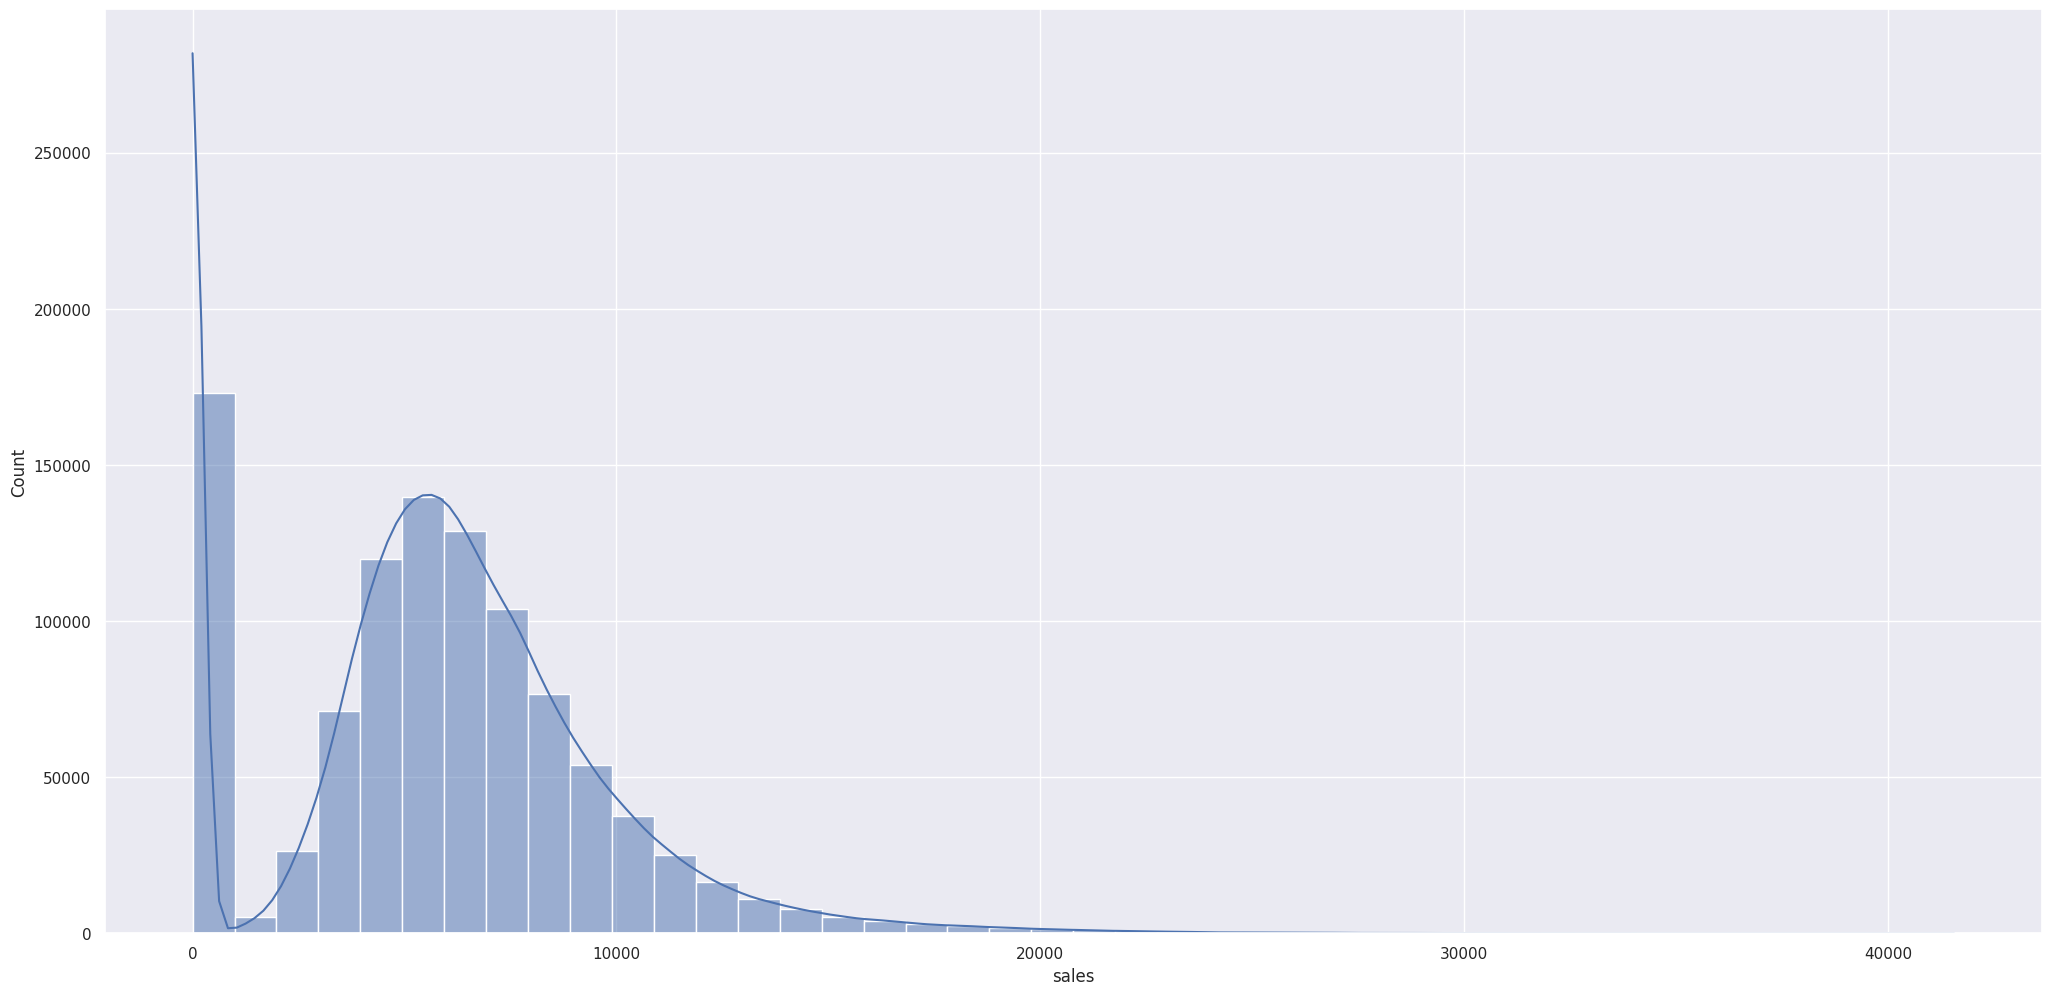

In [19]:
# Sales value distribution

sns.histplot( df1['sales'], kde=True, binwidth=1000 );


## Categorical Tendencies

In [20]:
# Check which values we have in each categorical column

cat_attributes.apply( lambda x: x.unique().shape ).T


,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_name,12


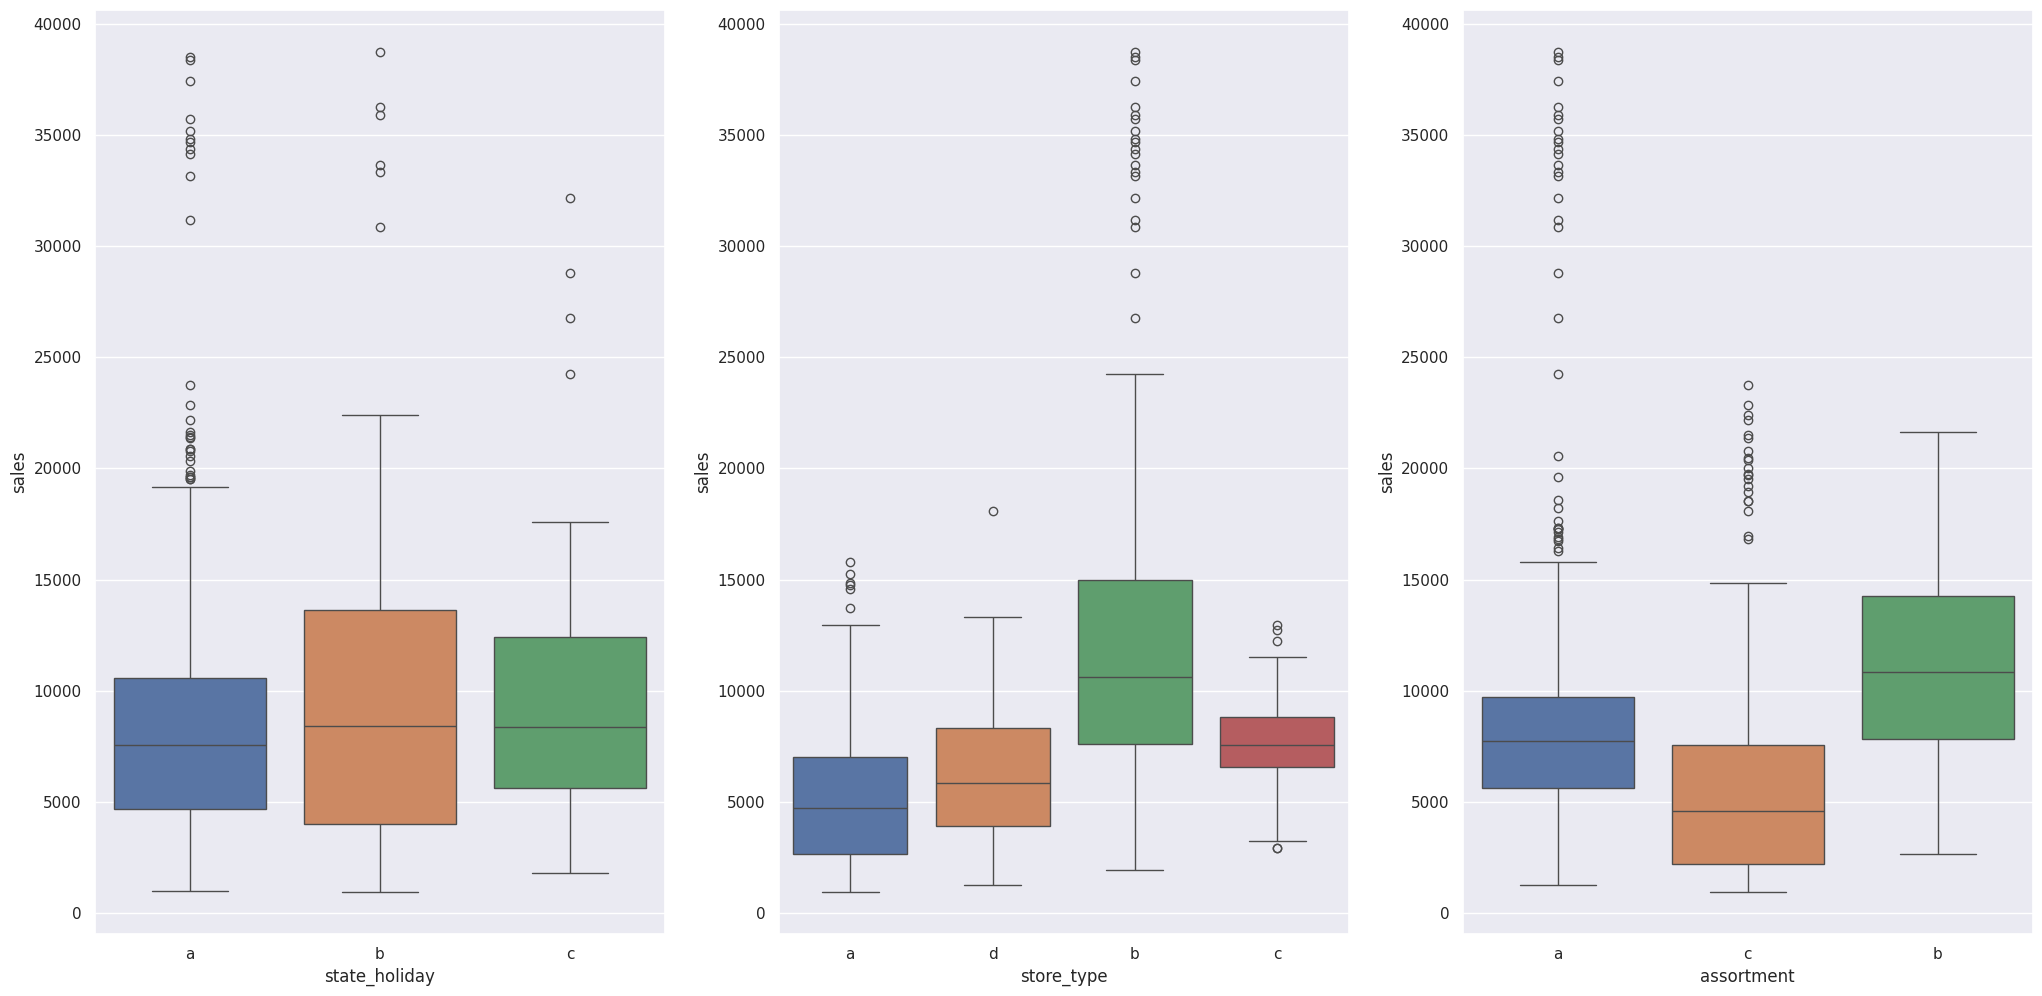

In [21]:
# Check the categorical variables behavior

aux = df1[( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux, hue='state_holiday' )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux, hue='store_type' )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux, hue='assortment' );


# Feature Engineering (Second Step)

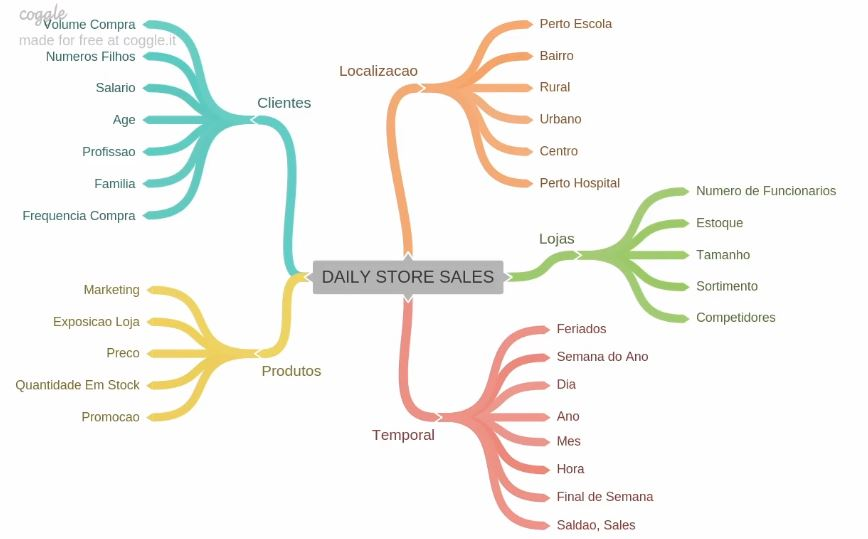

In [22]:
# Show the brainstorm done regarding some hypothesis 

Image( 'Brainstorm.JPG')


## Creating Hypothesis

### Store Hypothesis

**1.** Stores with the most number of employee should sell more;

**2.** Stores with the most capacity of warehouse should sell more;

**3.** Big Stores should sell more;

**4.** Stores with the most assortment should sell more;

**5.** Stores with the closest competitors should sell less;

**6.** Stores with the oldest competitors should sell less.

### Product Hypothesis

**1.** Stores which invest the most in marketing should sell more;

**2.** Stores with the most showcase of products should sell more;

**3.** Stores with the cheapest products should sell more;

**5.** Stores with the most agressive discounts should sell more;

**6.** Stores with active discount for a longer time should sell more;

**7.** Stores with the most days on sale should sell more;

**8.** Stores with frequent discounts should sell more.

### Time Hypothesis

**1.** Stores which open at holidays should sell more;

**2.** Stores should sell more throughout the years;

**3.** Stores should sell more in the second semester;

**4.** Stores should sell more after the 10th of the each month;

**5.** Stores should sell less in the weekends;

**6.** Stores should sell less during scholars holidays

## Final Hypothesis List

**1.** Stores with the most assortment should sell more;

**2.** Stores with the closest competitors should sell less;

**3.** Stores with the oldest competitors should sell more;

**4.** Stores with active discount for a longer time should sell more;

**5.** Stores with the most days on sale should sell more;

**6.** Stores with frequent discounts should sell more;

**7.** Stores should sell more during Christmas;

**8.** Stores should sell more throughout the years;

**9.** Stores should sell more in the second semester;

**10.** Stores should sell more after the 10th of the each month;

**11.** Stores should sell less in the weekends;

**12.** Stores should sell less during scholars holidays.


## Adding new features

In [23]:
# Checkpoint 2

df2 = df1.copy()


In [24]:
# Year, month, year, Year of week, Year week ( Creating Columns related to specific time )

df2['year'] = df2['date'].dt.year
df2['month'] = df2['date'].dt.month
df2['day'] = df2['date'].dt.day
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Competition since

df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year'].astype( str ) + '-' + df2['competition_open_since_month'].astype( str ) )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )

# Promo Since

df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )

# Assortment

df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday

df2['state_holiday'] = df2['state_holiday'].map( {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0':'regular_day' } )


In [25]:
df2.head( 10 )

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_name,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
5,6,5,2015-07-31,5651,589,1,1,regular_day,1,a,basic,310.0,12,2013,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
6,7,5,2015-07-31,15344,1414,1,1,regular_day,1,a,extended,24000.0,4,2013,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2013-04-01,28,2015-07-27,0
7,8,5,2015-07-31,8492,833,1,1,regular_day,1,a,basic,7520.0,10,2014,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2014-10-01,10,2015-07-27,0
8,9,5,2015-07-31,8565,687,1,1,regular_day,1,a,extended,2030.0,8,2000,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
9,10,5,2015-07-31,7185,681,1,1,regular_day,1,a,basic,3160.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


## Filtering

In [26]:
# Checkpoint 3

df3 = df2.copy()


In [27]:
# Filter the lines where the stores weren't open

df3 = df3.loc[( df3['open'] != 0 ) & df3['sales'] > 0, :]

# Select just the columns that will be able to work with

drop_columns = ['customers', 'open', 'month_name', 'promo_interval']
df3 = df3.drop( drop_columns, axis=1 )


# EDA ( Exploratory Data Analyze )

In [28]:
# Checkpoint 4

df4 = df3.copy()


## Univariate Analyze

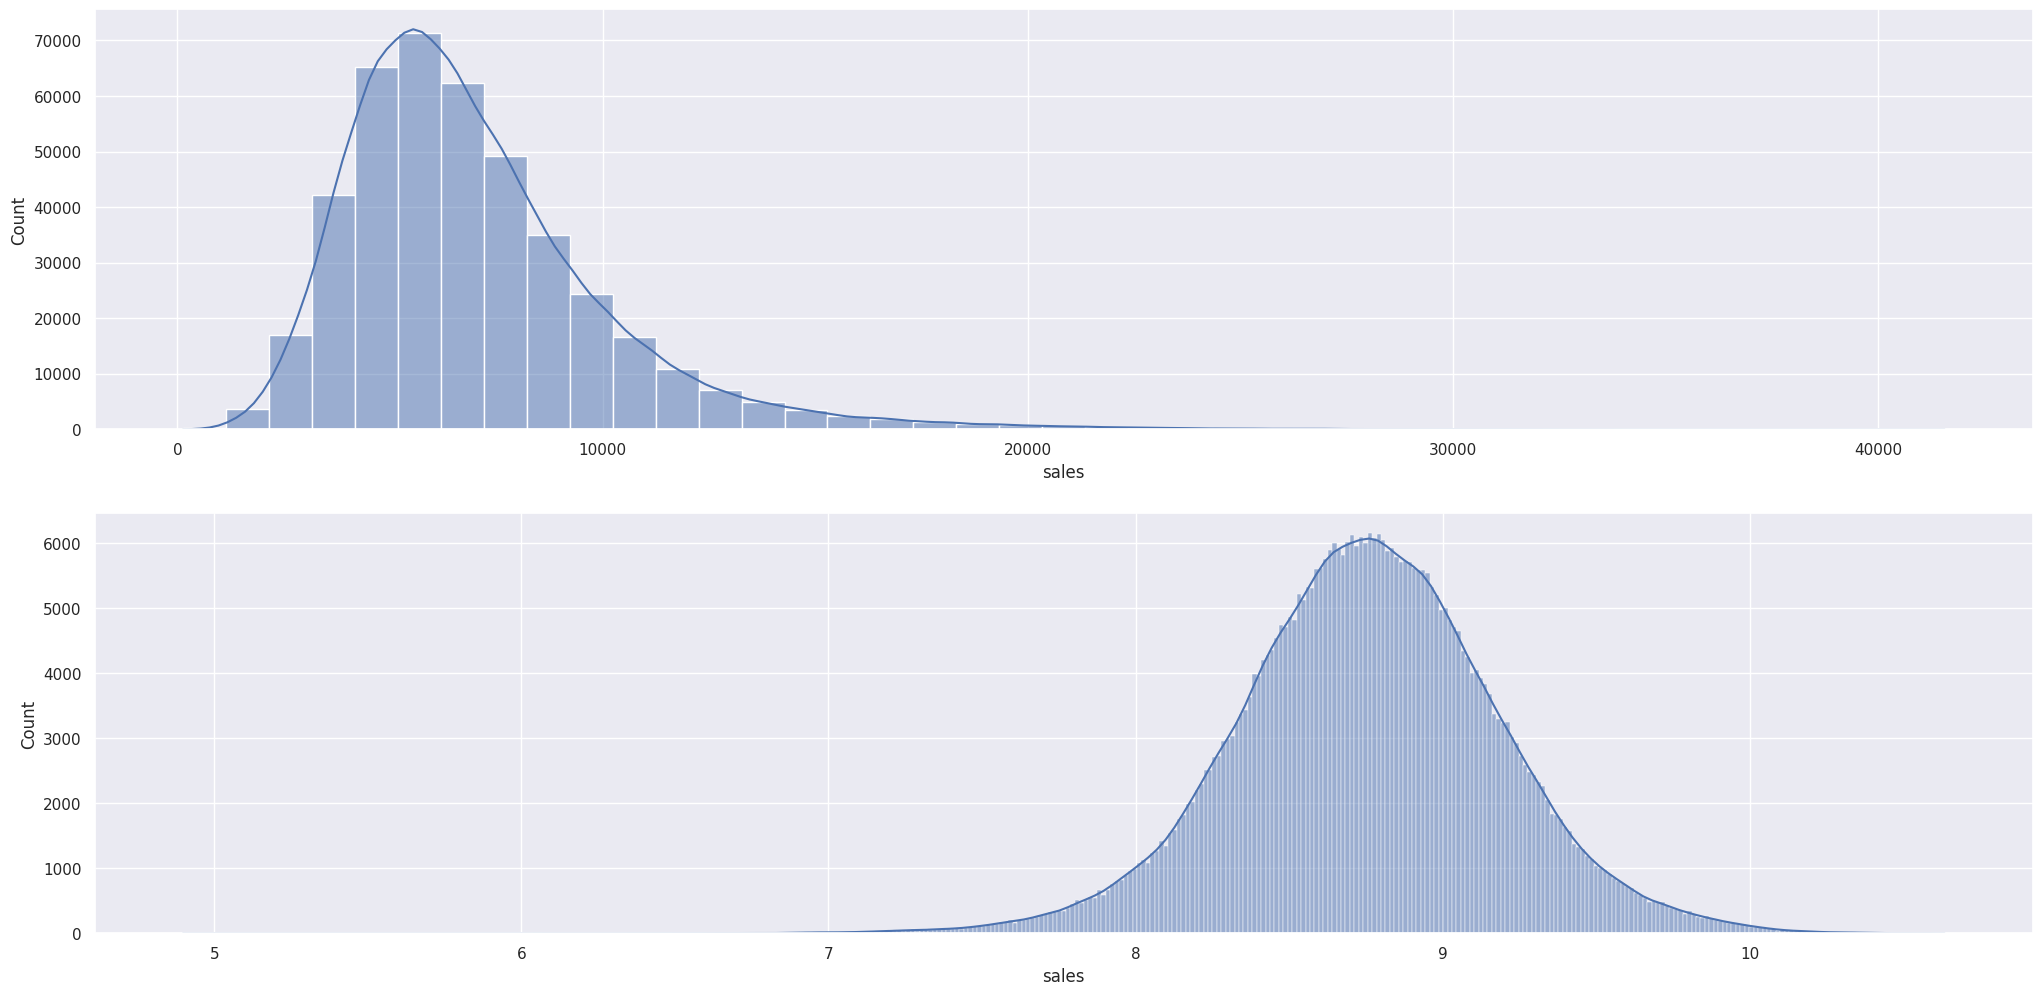

In [29]:
# Check the behavior of our variable response, Sales value distribution withou the stores closed

plt.subplot( 2, 1, 1 )
sns.histplot( df4['sales'], kde=True, binwidth=1000 );

plt.subplot( 2, 1, 2 )
sns.histplot( np.log1p( df4['sales'] ), kde=True );


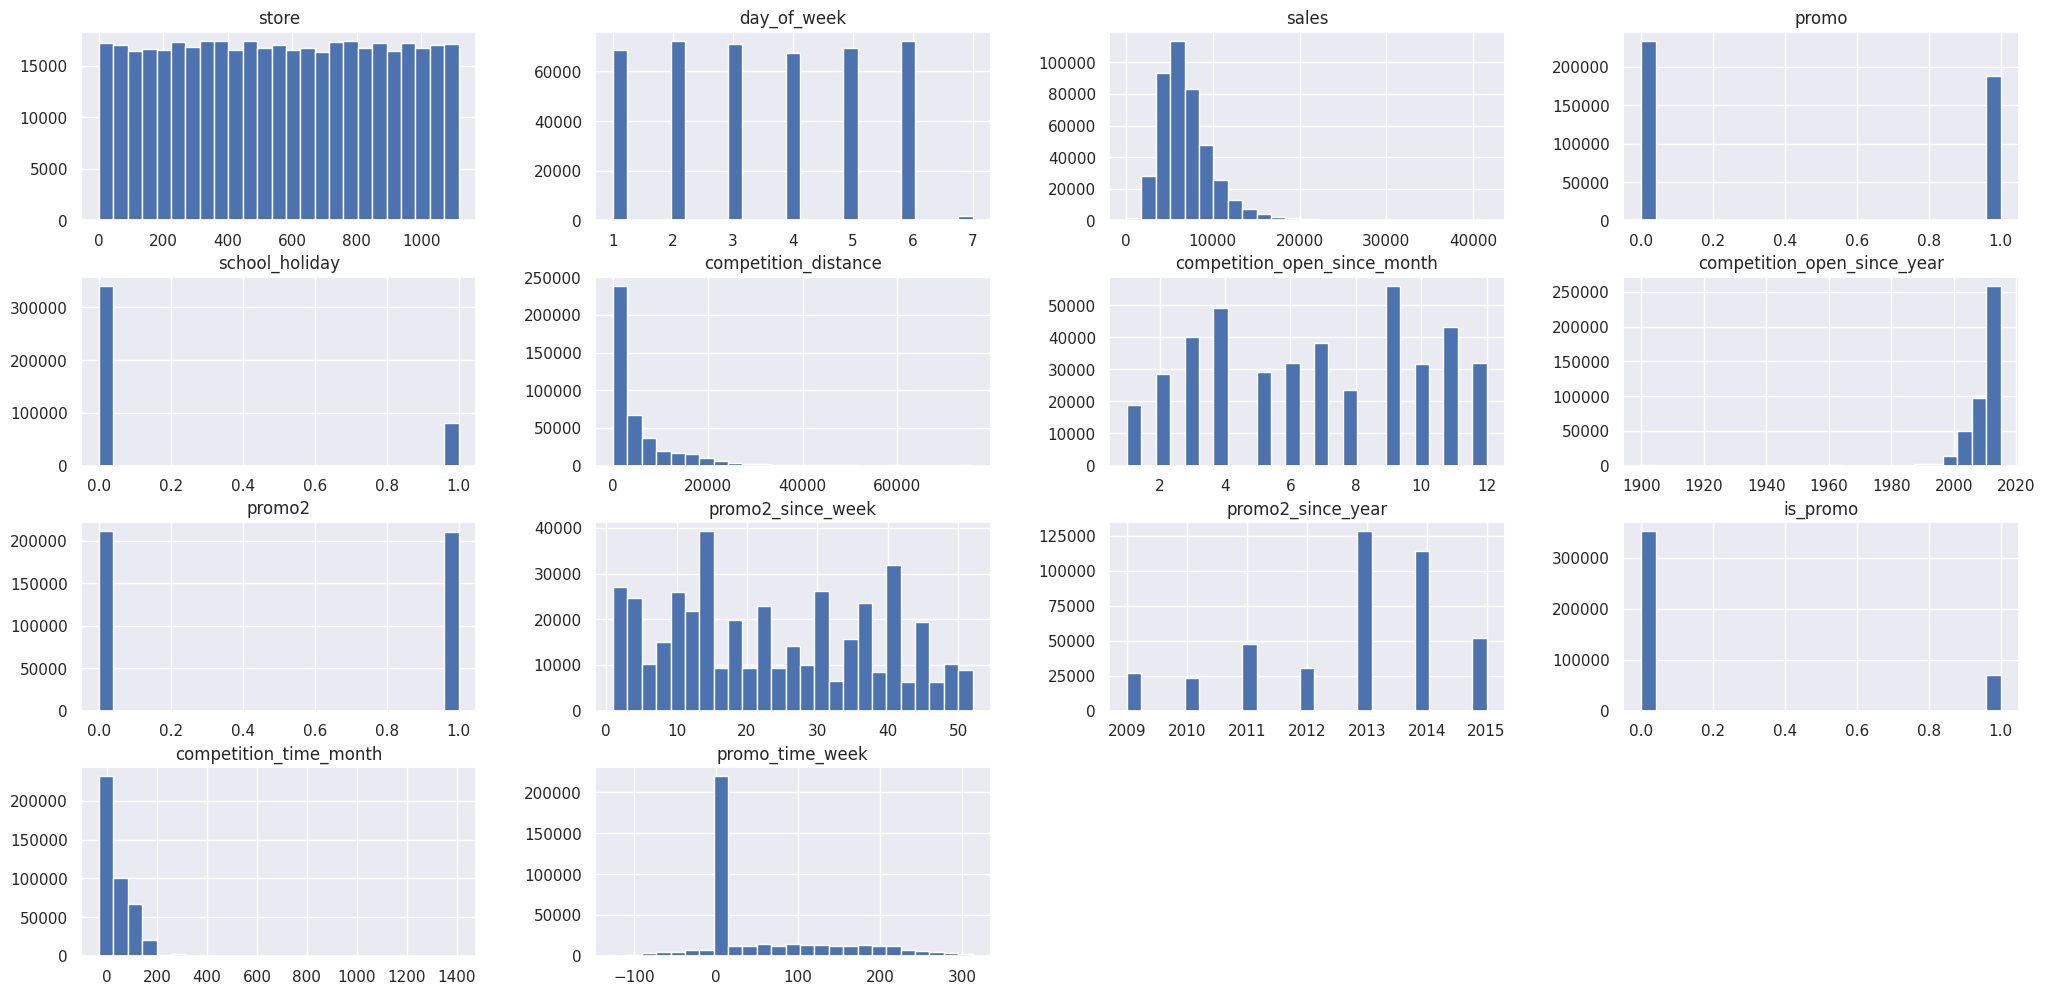

In [30]:
# Analyse each variable to see their behaviors individualy

df4.select_dtypes( include=['int64', 'float64'] ).hist( bins=25 );


## Categorical Variable

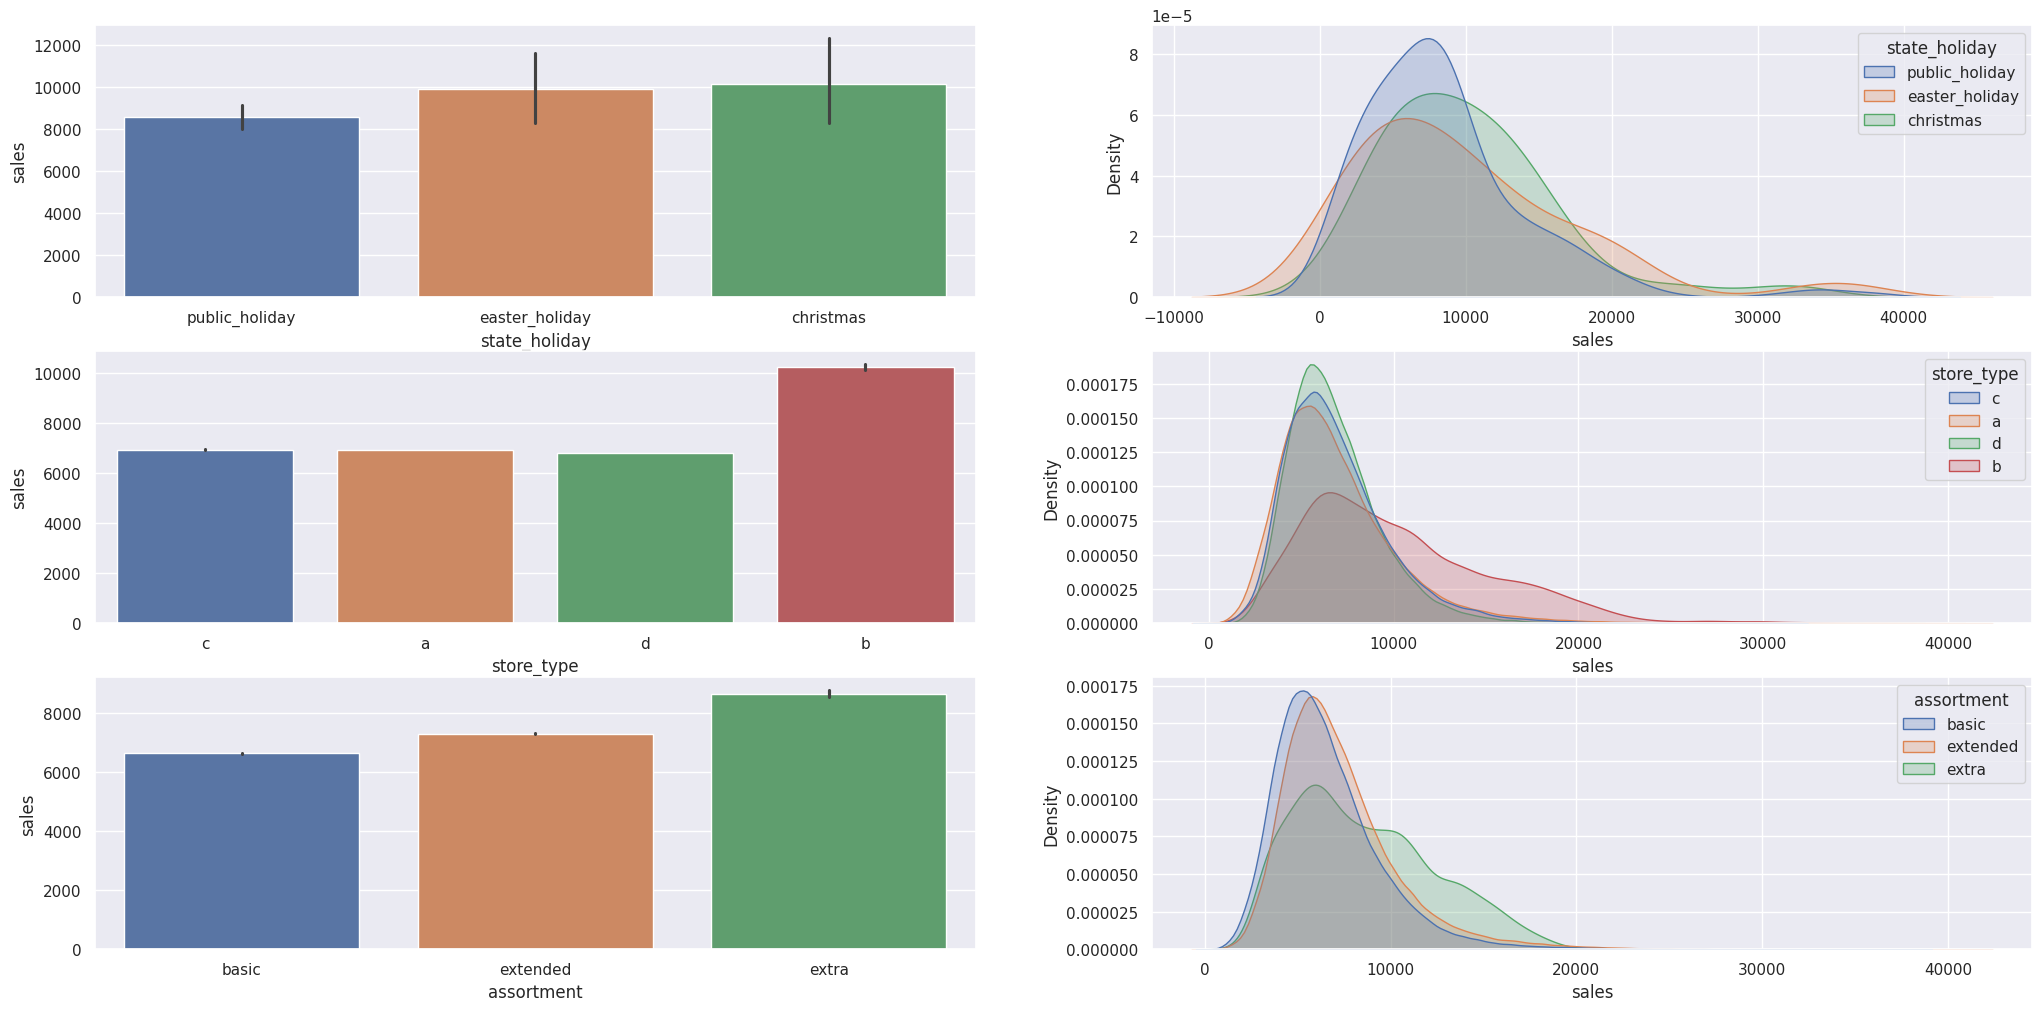

In [31]:
# State holiday

plt.subplot( 3, 2, 1 )
aux1 = df4[df4['state_holiday'] != 'regular_day']
sns.barplot( data=aux1, x='state_holiday', y='sales', hue='state_holiday' )

plt.subplot( 3, 2, 2 )
sns.kdeplot( data=aux1, x='sales', hue='state_holiday', fill=True, common_norm=False )

# Store_type

plt.subplot( 3, 2, 3 )
sns.barplot( data=df4, x='store_type', y='sales', hue='store_type' );

plt.subplot(3, 2, 4)
sns.kdeplot( data=df4, x='sales', hue='store_type', fill=True, common_norm=False );

# Assortment

plt.subplot(3, 2, 5)
sns.barplot( data=df4, x='assortment', y='sales', hue='assortment' )

plt.subplot(3, 2, 6)
sns.kdeplot( data=df4, x='sales', hue='assortment', fill=True, common_norm=False );


## Bivariate Analyze

### H1. Stores with the most assortment should sell more
**False** Stores with bigger assortment sell less

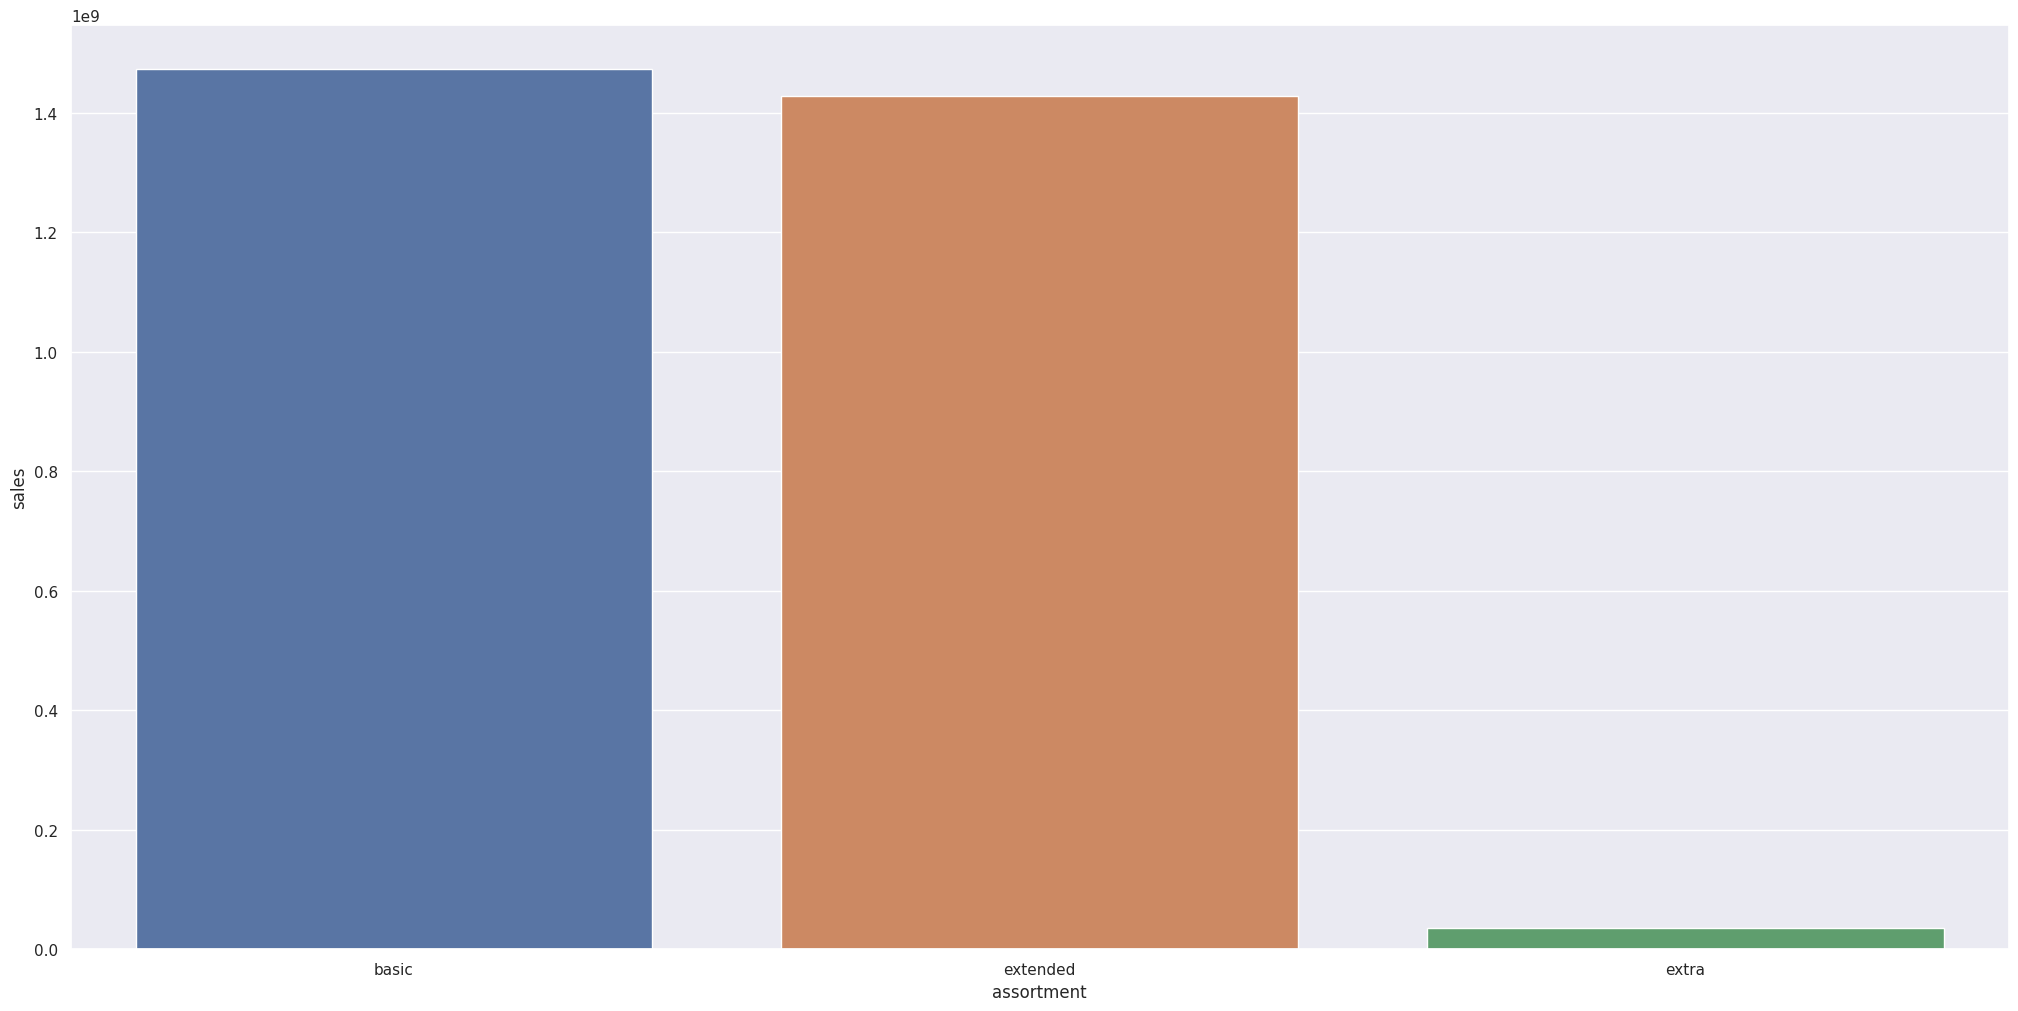

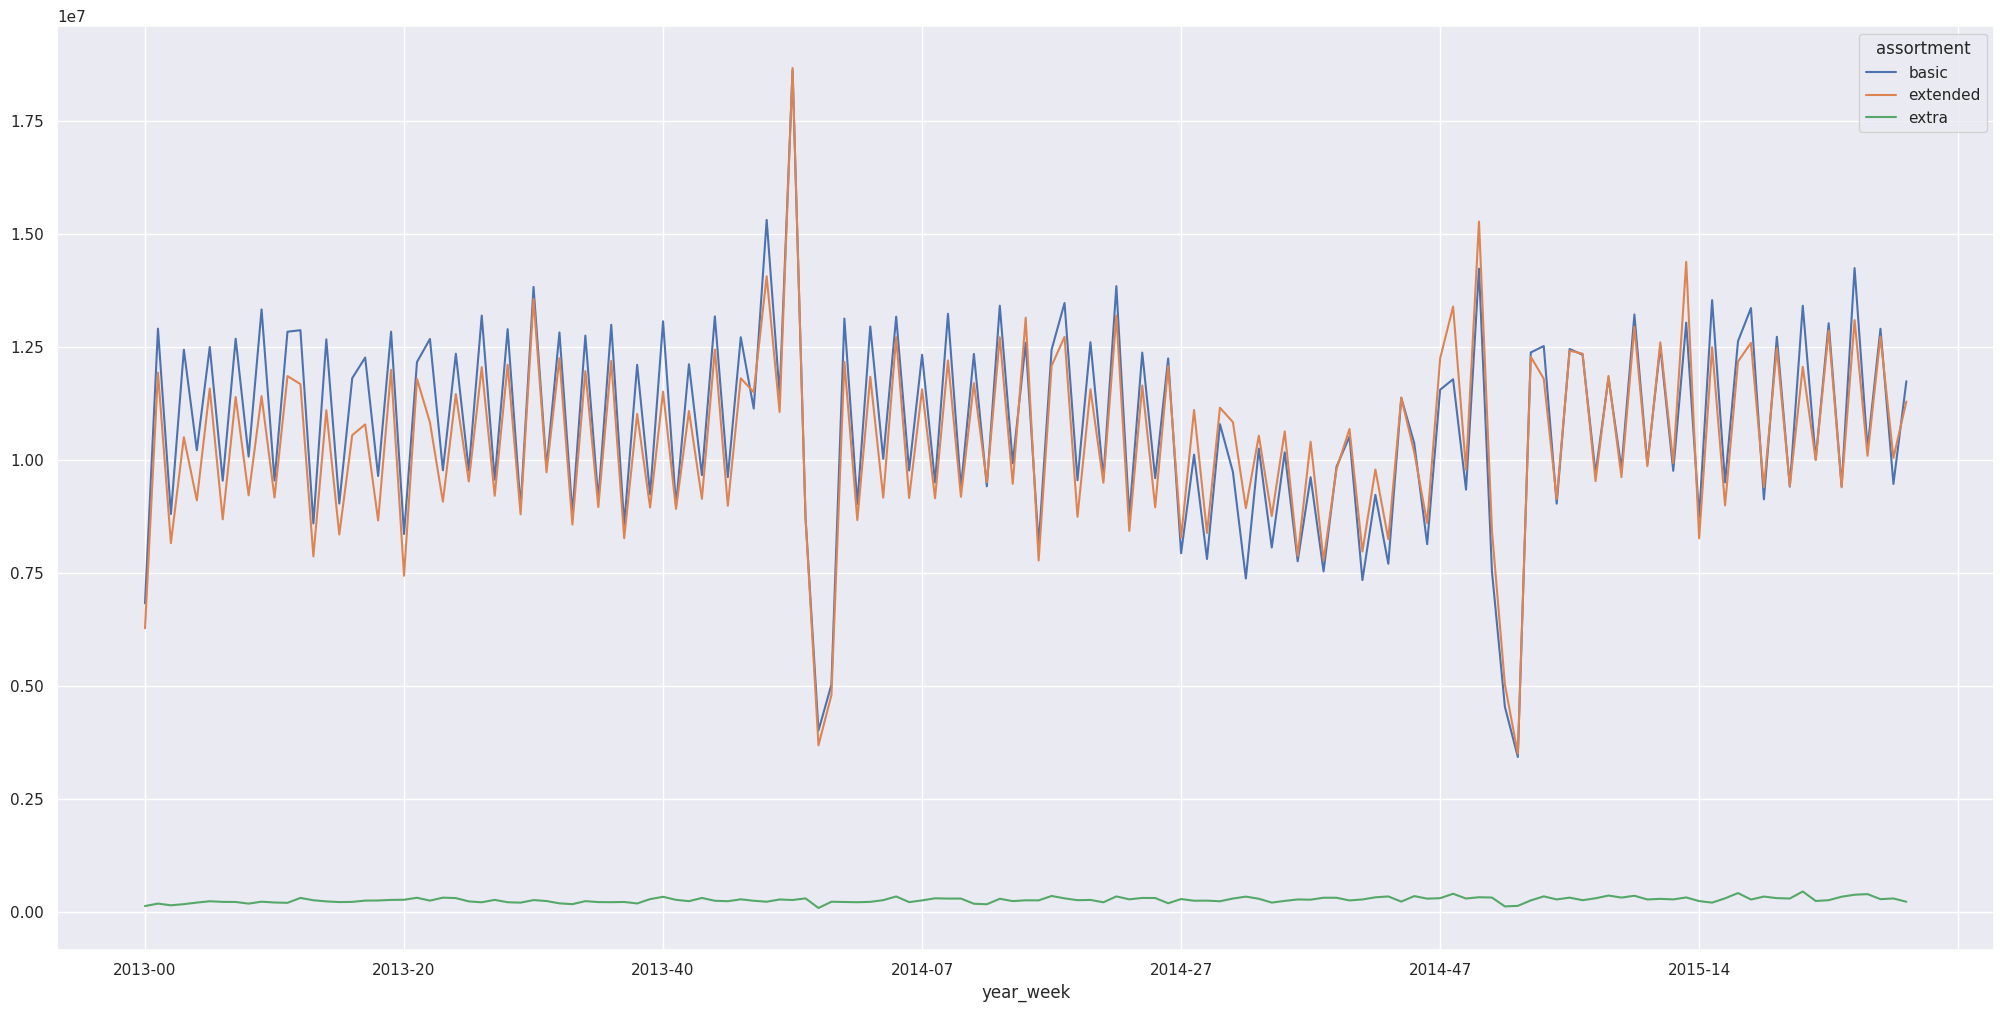

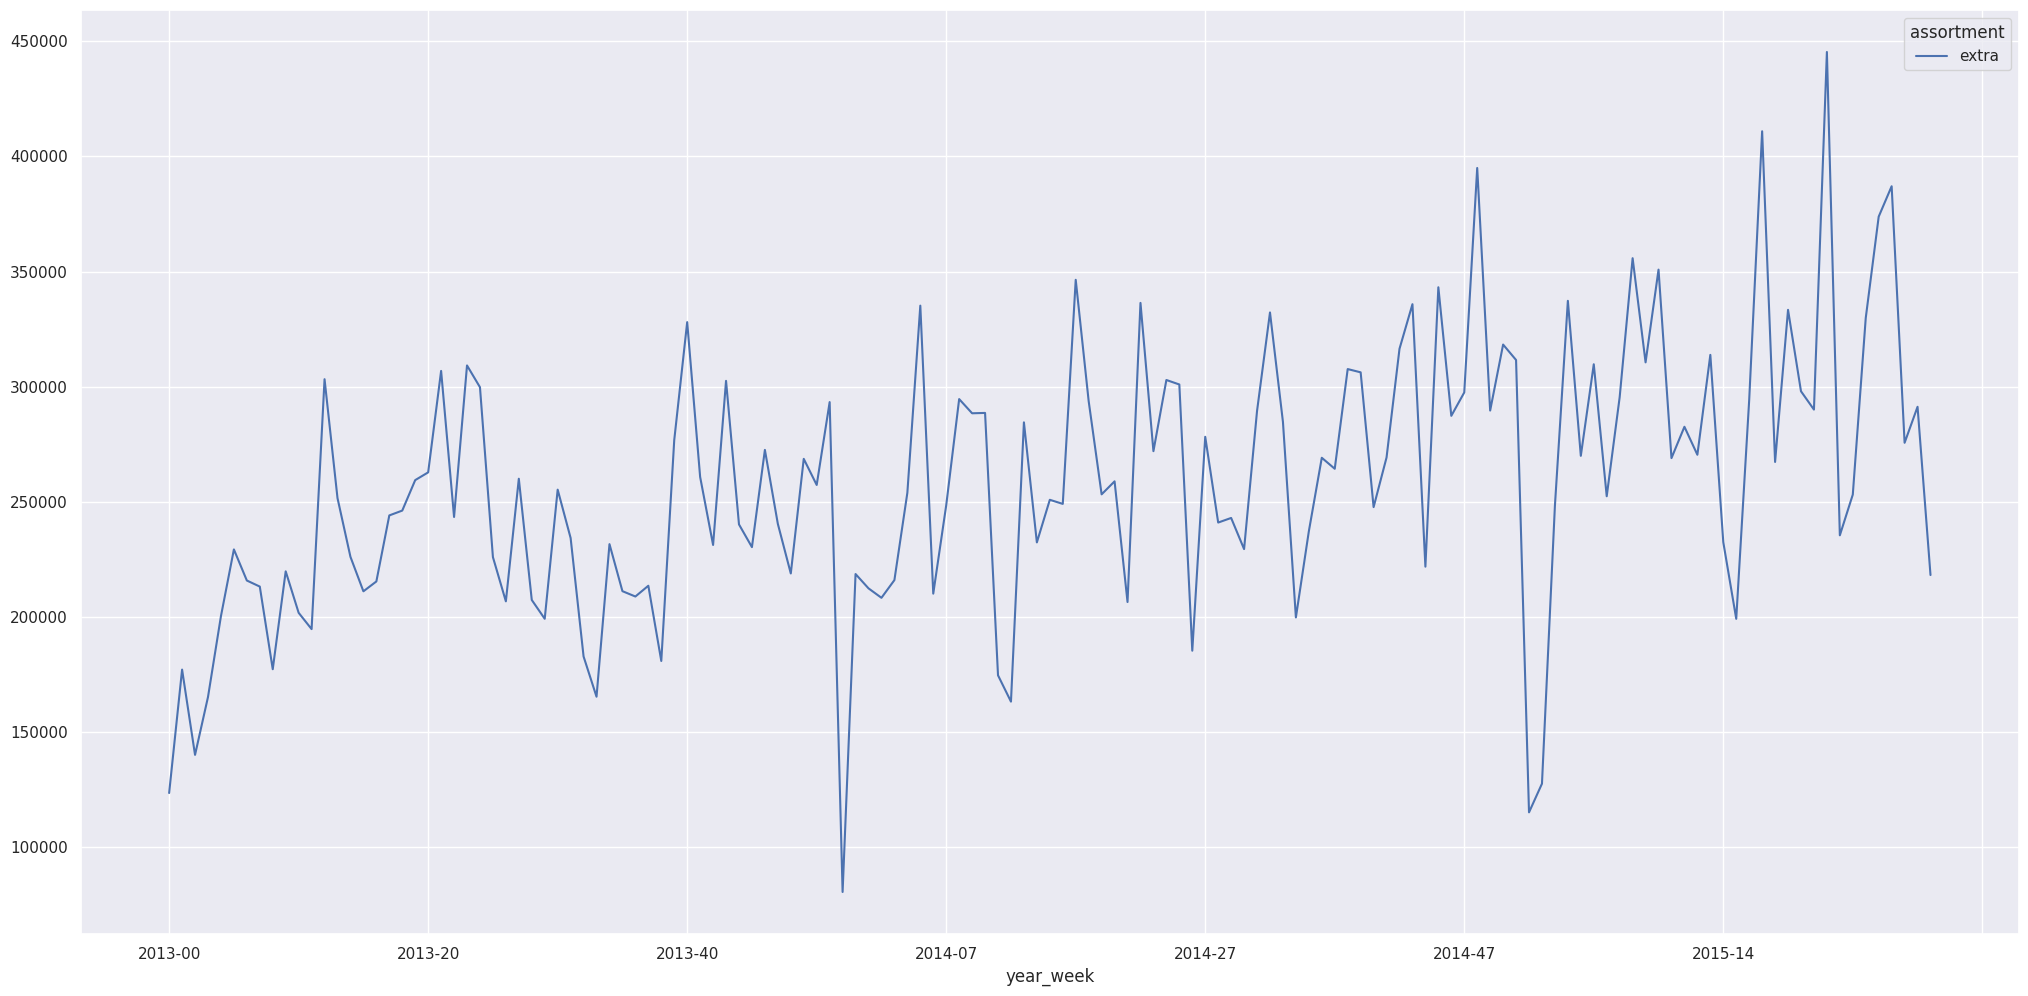

In [32]:
# Test if the Stores with bigger assortment sell more

# Group the segments, then sum their sales

aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1, hue='assortment' );

# Now let's see the behavior throughout the years

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()


# We need to create one more chart to check the assortment (extra), because of its huge difference from the other two variable

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();


### H2. Stores with the closest competitors should sell less
**False** Stores with closest competitors sell more

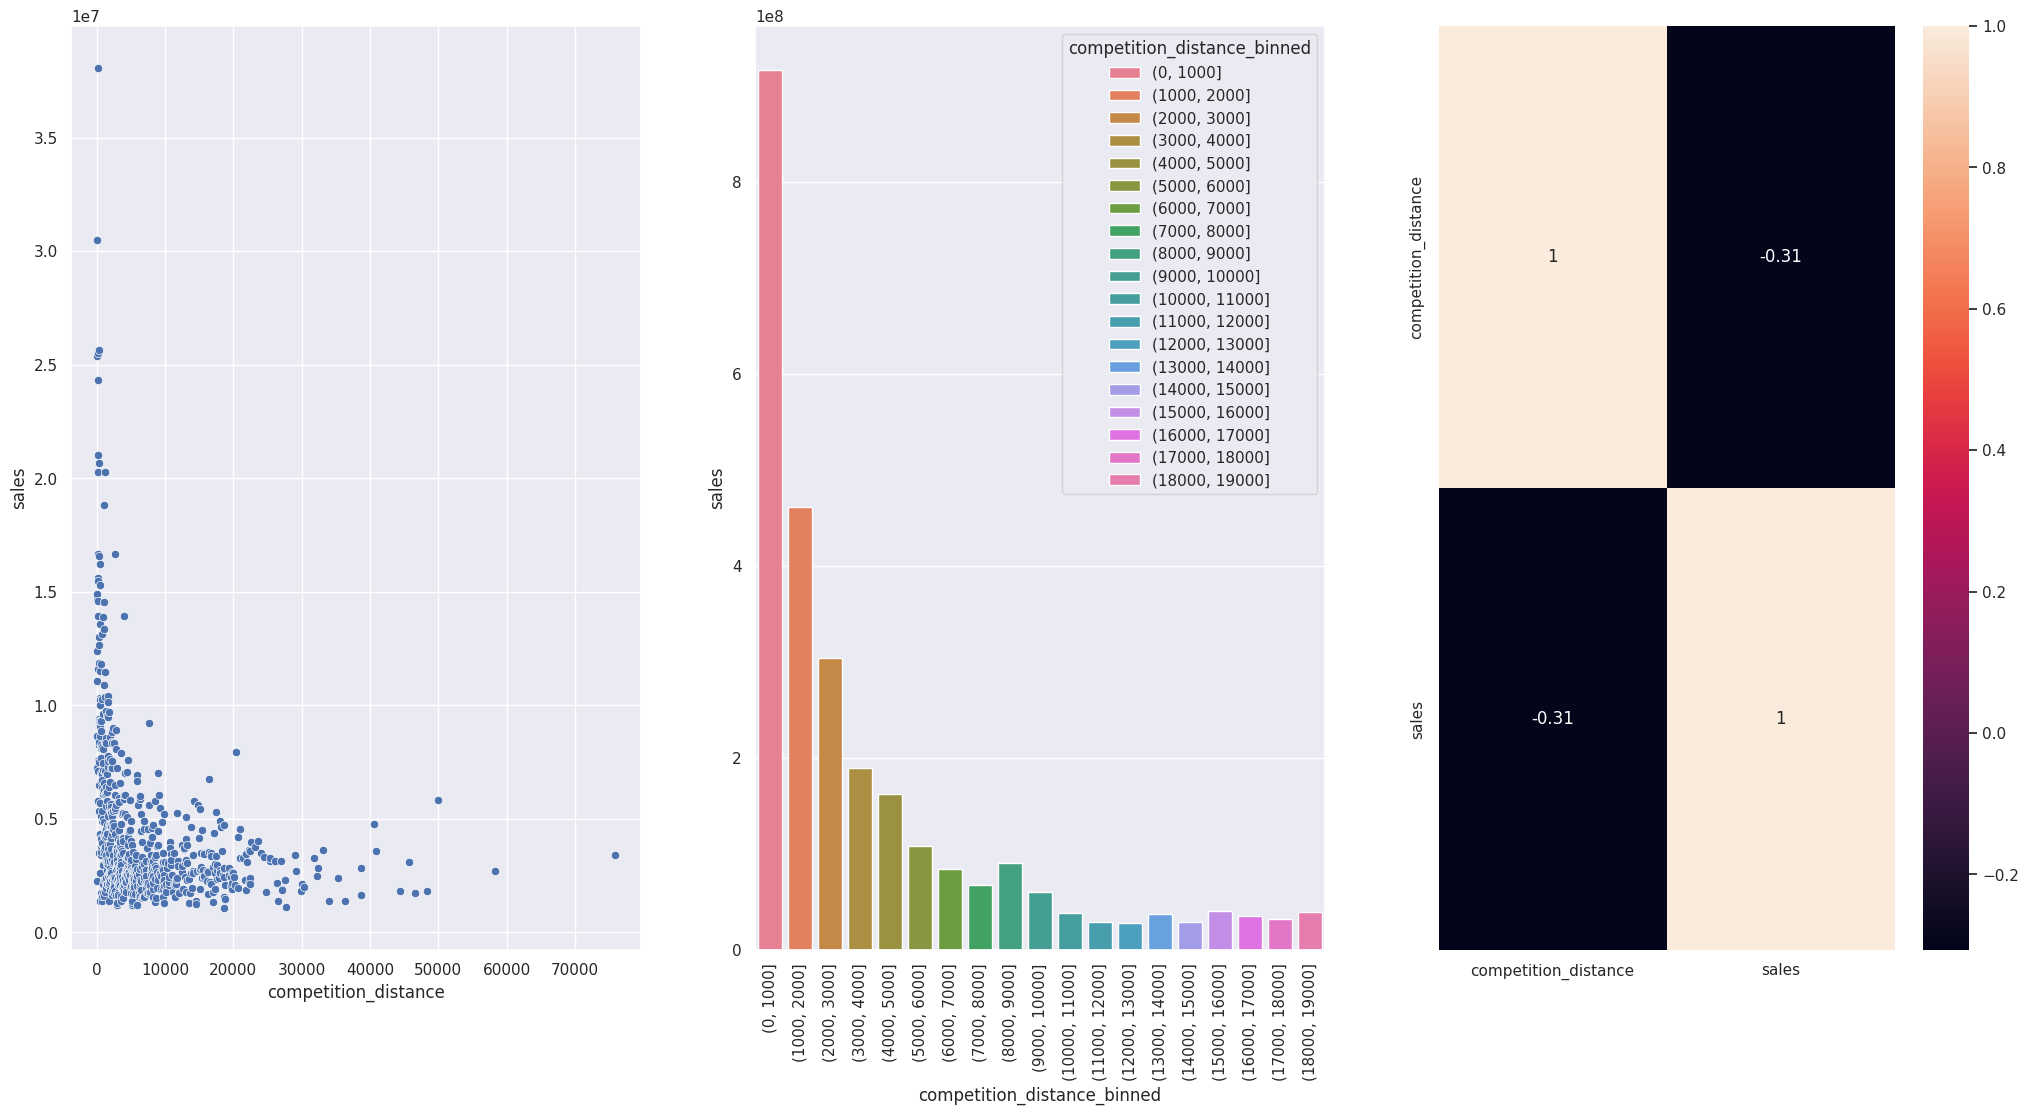

In [33]:
# Check the relation between sales and competition distance

aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

# Scatterplot help us to show the distribution of sales in the various distance range

plt.subplot( 1, 3, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 );

# Let's create a more visible chart, Bins make the data divided in groups to have more visibility

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2, hue='competition_distance_binned' );

# Rotate the x label to be alble to see the subtitles

plt.xticks( rotation=90 );

# Pearson correlation heatmap

plt.subplot( 1, 3, 3 )
corr_matrix = aux1[['competition_distance', 'sales']].corr( method='pearson' )

x = sns.heatmap( corr_matrix, annot=True )


### H3. Stores with the oldest competitors should sell more
**False** Stores with oldest competitors sell less

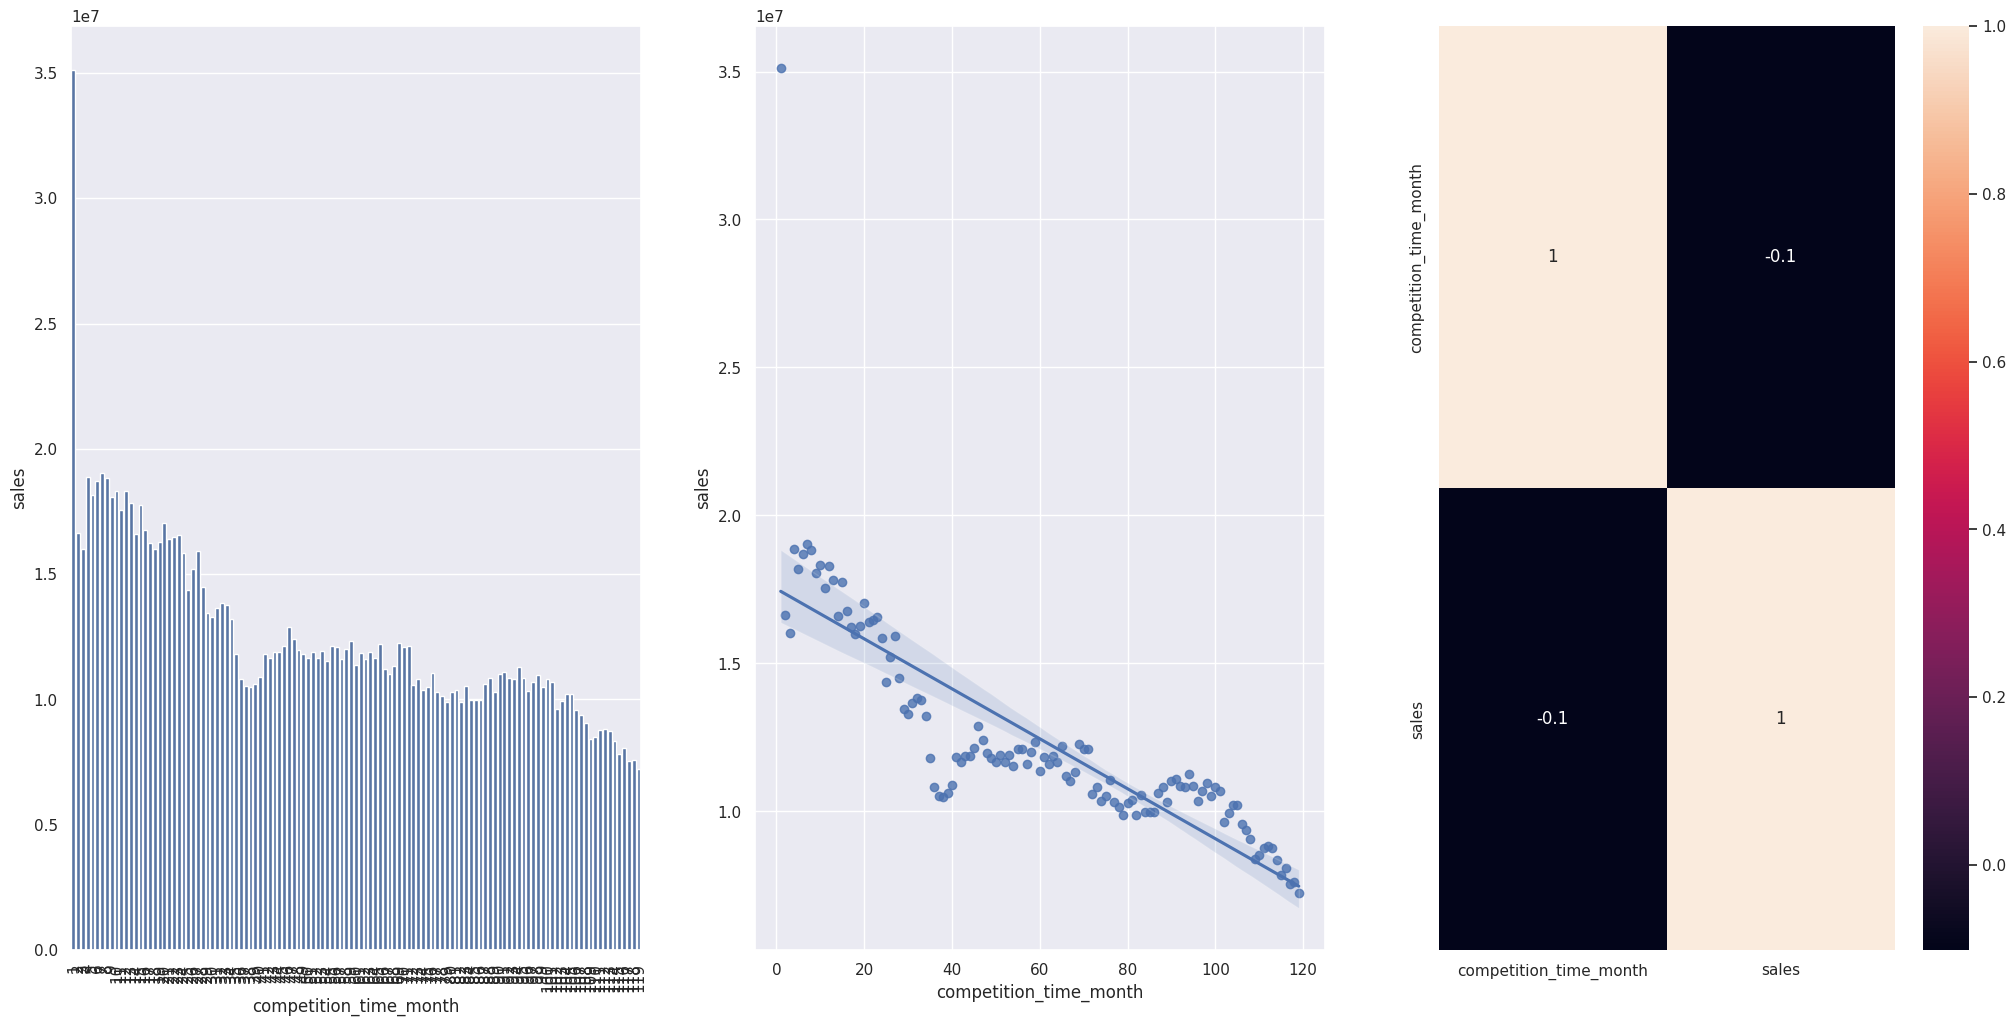

In [34]:
# Group the competition by time to its influence in the sales

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()

# Make a filter competition time that retuns a max 120 months and different from 0
    
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] > 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot(1, 3, 2)
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

# Pearson correlation heatmap

plt.subplot( 1, 3, 3 )
corr_matrix = aux1[['competition_time_month', 'sales']].corr( method='pearson' )
x = sns.heatmap( corr_matrix, annot=True )


### H4. Stores with active discount for a longer time should sell more
**False** Stores with active discount for a longer time sell less after a certain time

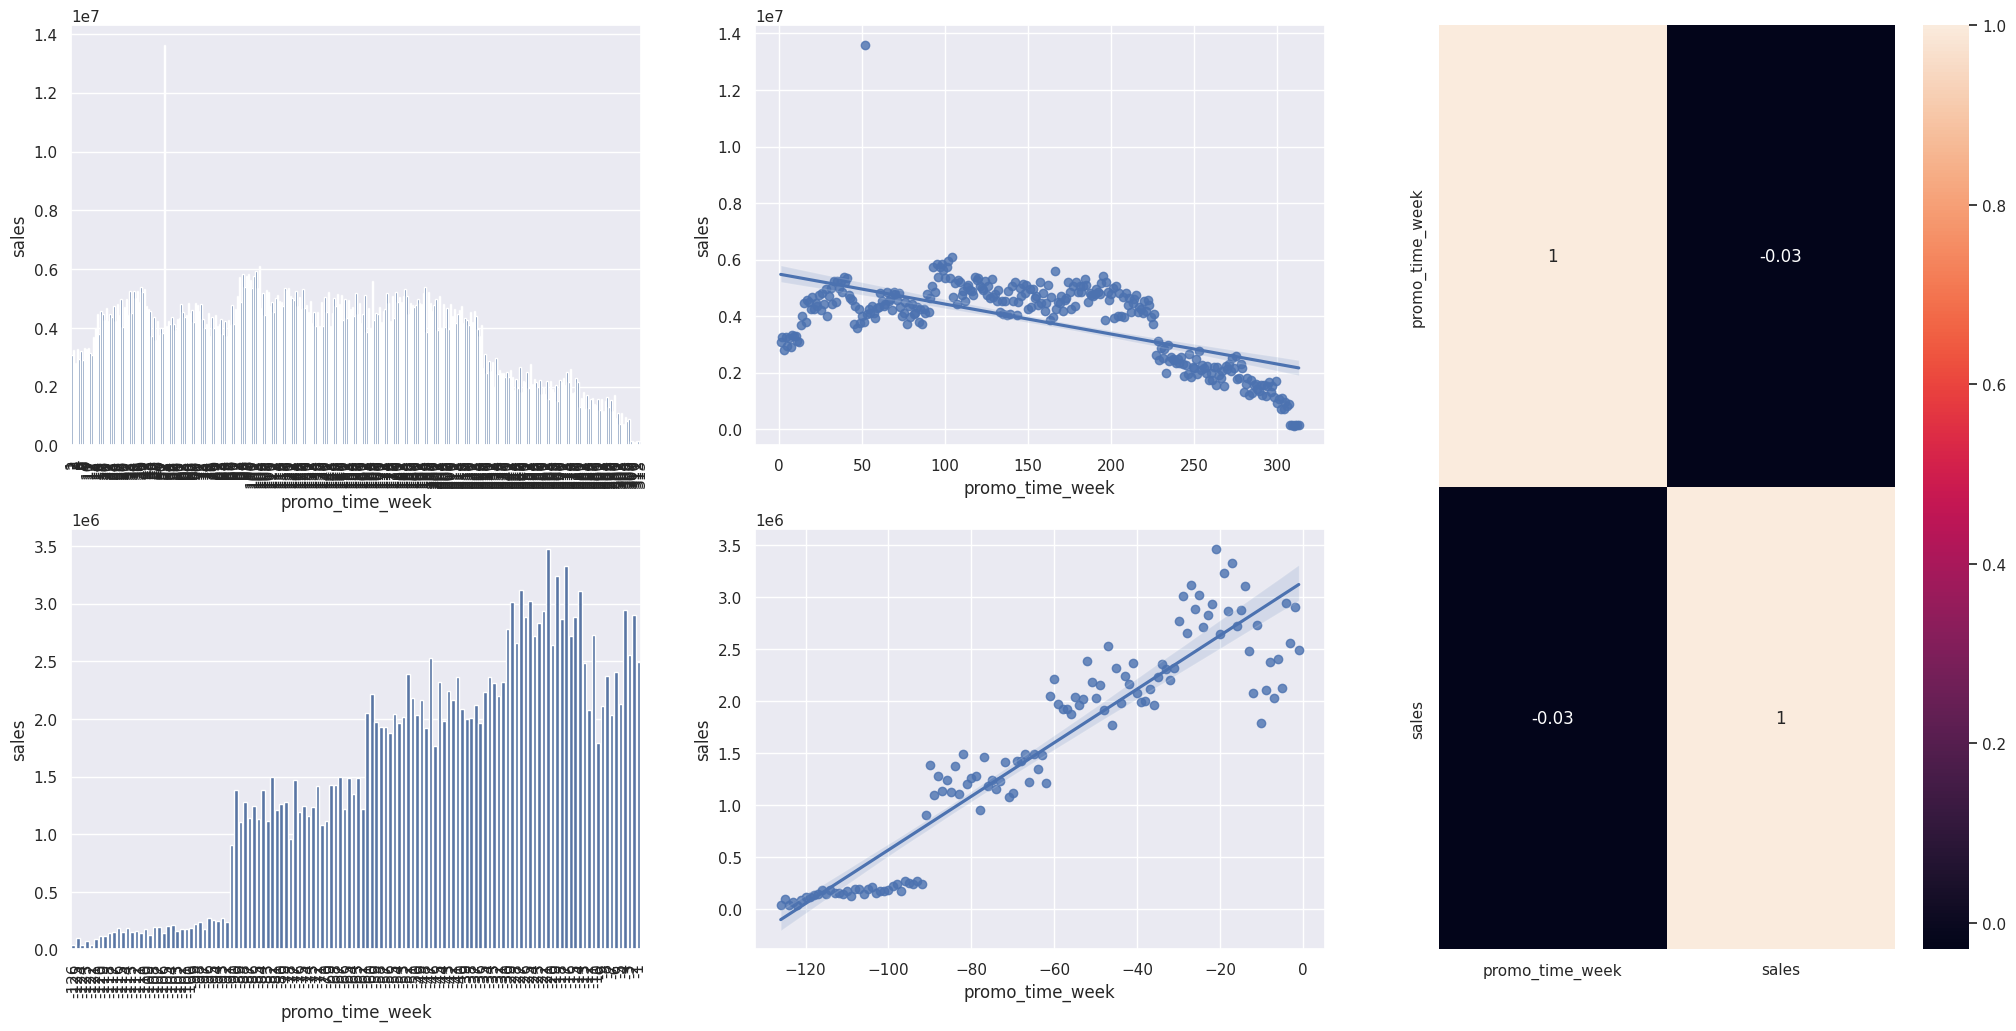

In [35]:
# check how the promo time affects the sales

aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).sum().reset_index()

# Create a Grid

grid = GridSpec( 2, 3 )

plt.subplot( grid[0,0] )

# Extended Promo

aux2 = aux1[aux1['promo_time_week'] > 0] 
sns.barplot( x='promo_time_week', y='sales', data= aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0, 1] )

sns.regplot( x='promo_time_week', y='sales', data=aux2 );

# Regular Promo

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0 ] 
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


### <s>**H5.** Stores with the most days on sale should sell more</s>

### H6. Stores with frequent discounts should sell more
**False** Stores which stay on sales more often sell less

In [36]:
# Check how much the stores with and without discount have sold

df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().sort_values( 'sales', ascending=False ).reset_index()


,promo,promo2,sales
0,1,0,812324138
1,0,0,741976980
2,1,1,735532810
3,0,1,645952357


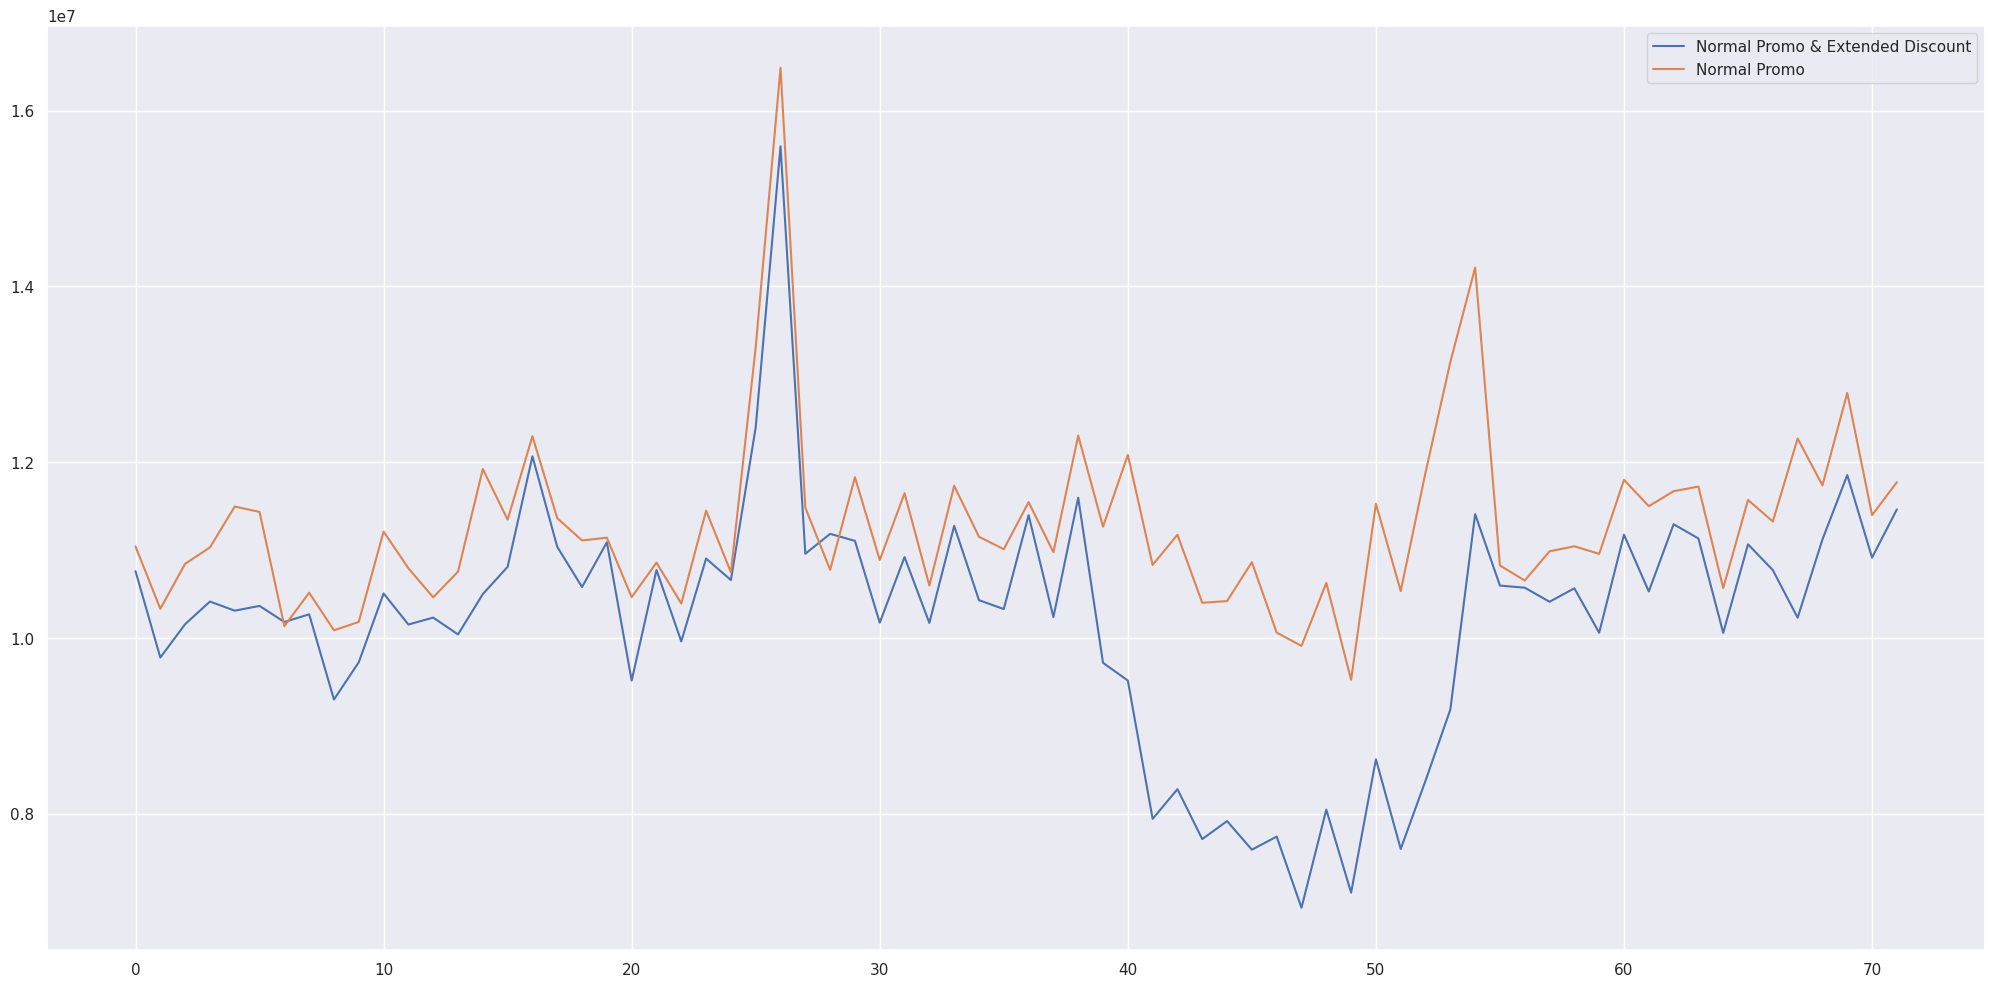

In [37]:
# Nos let's check the perfomance throughout time

aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Normal Promo & Extended Discount', 'Normal Promo' ] );


### H7. Stores should sell more during Christmas
**False** Store sell less on Christmas

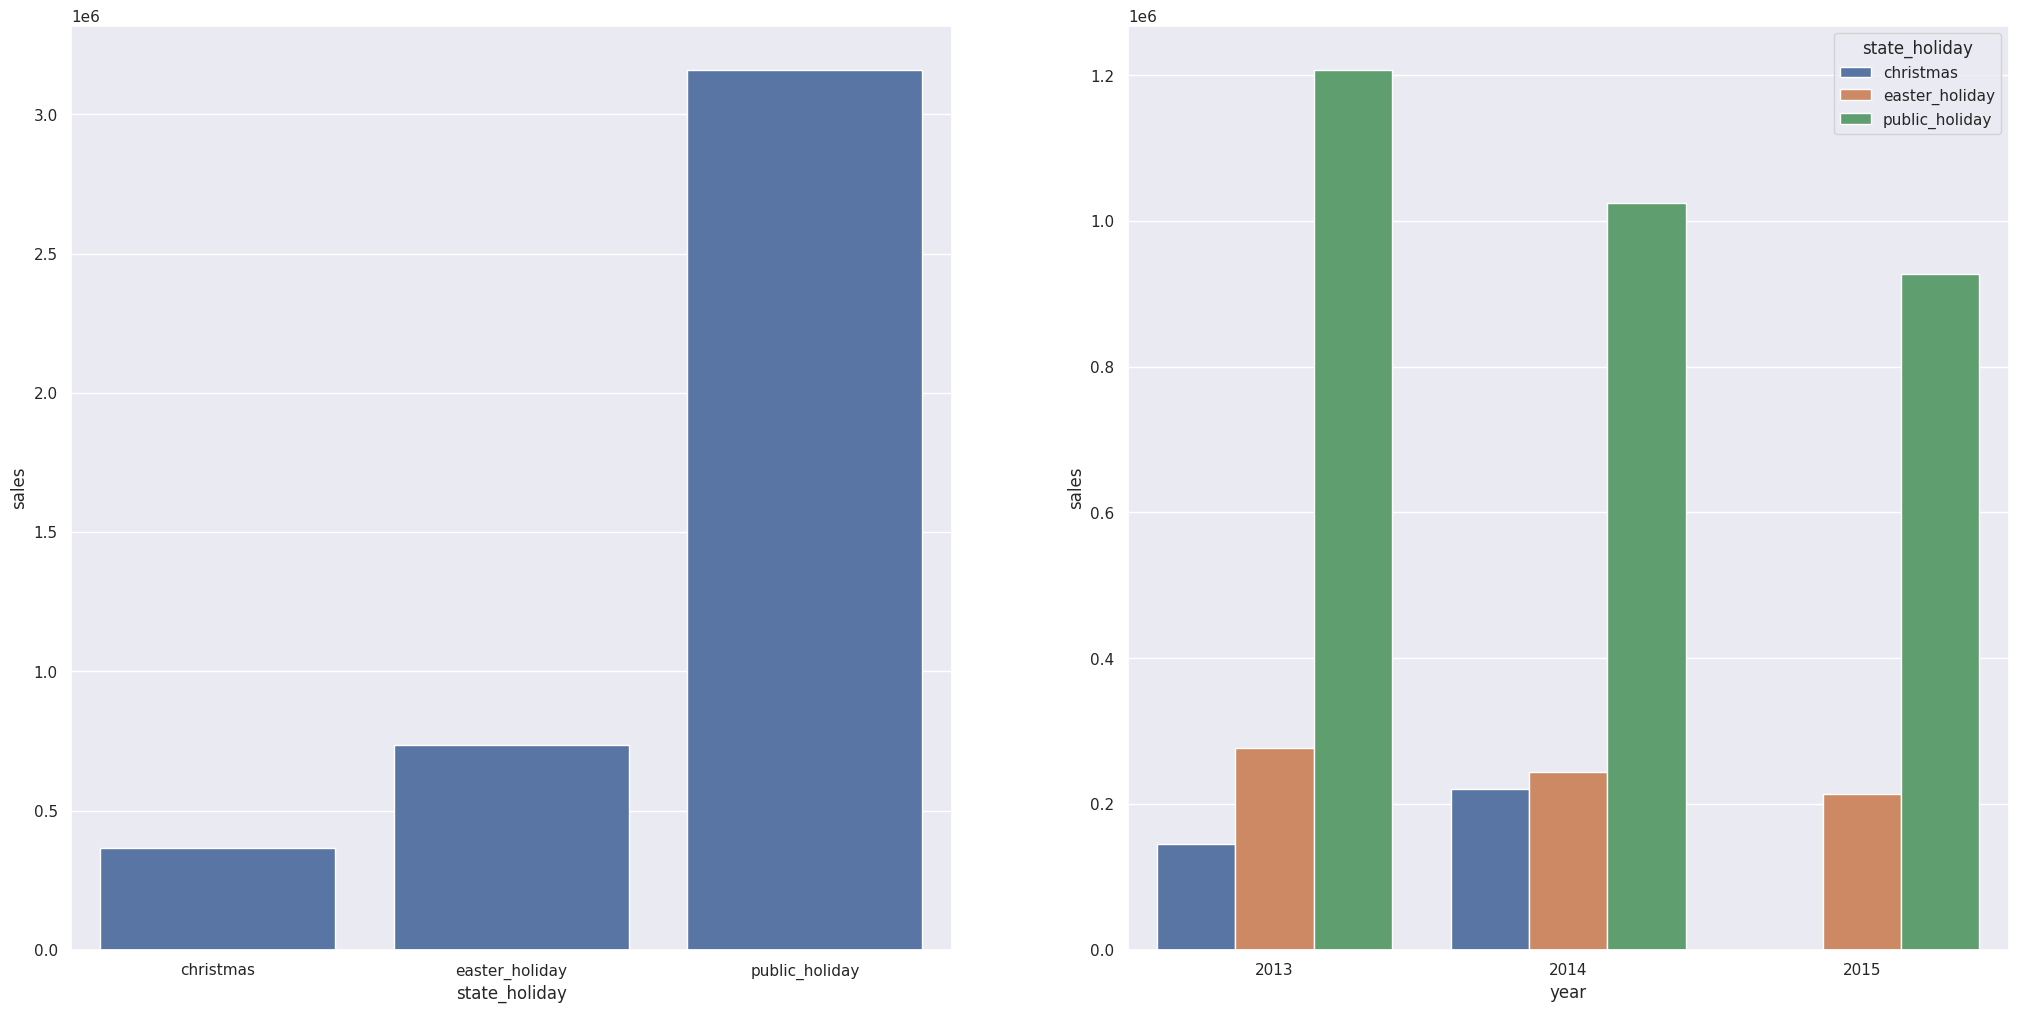

In [38]:
# Filter the Holiday

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );


### **H8.** Stores should sell more throughout the years
**False** Stores sell less throughout the years

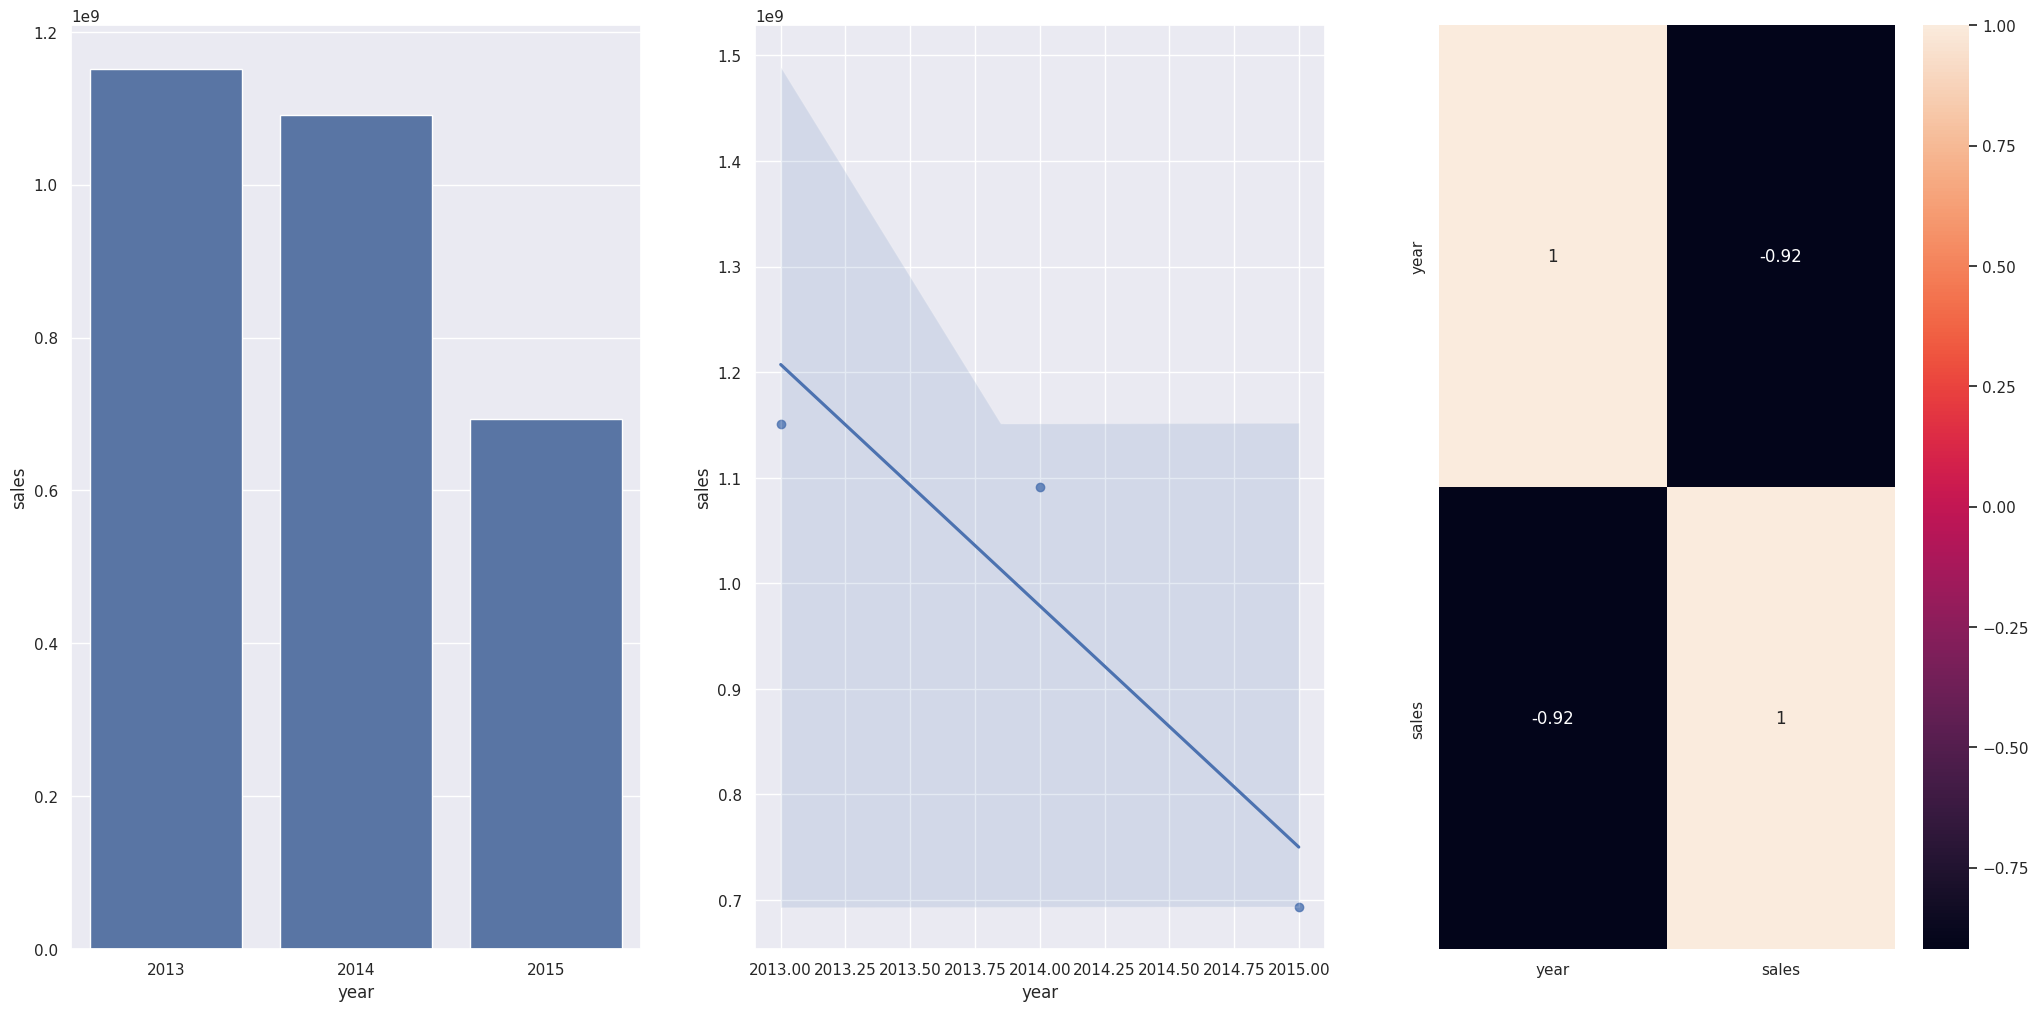

In [39]:
# Group the sales in the years, ( Note that the last year wasn't completed )

aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H9. Stores should sell more in the second semester
**False** Stores sell less in the second semester

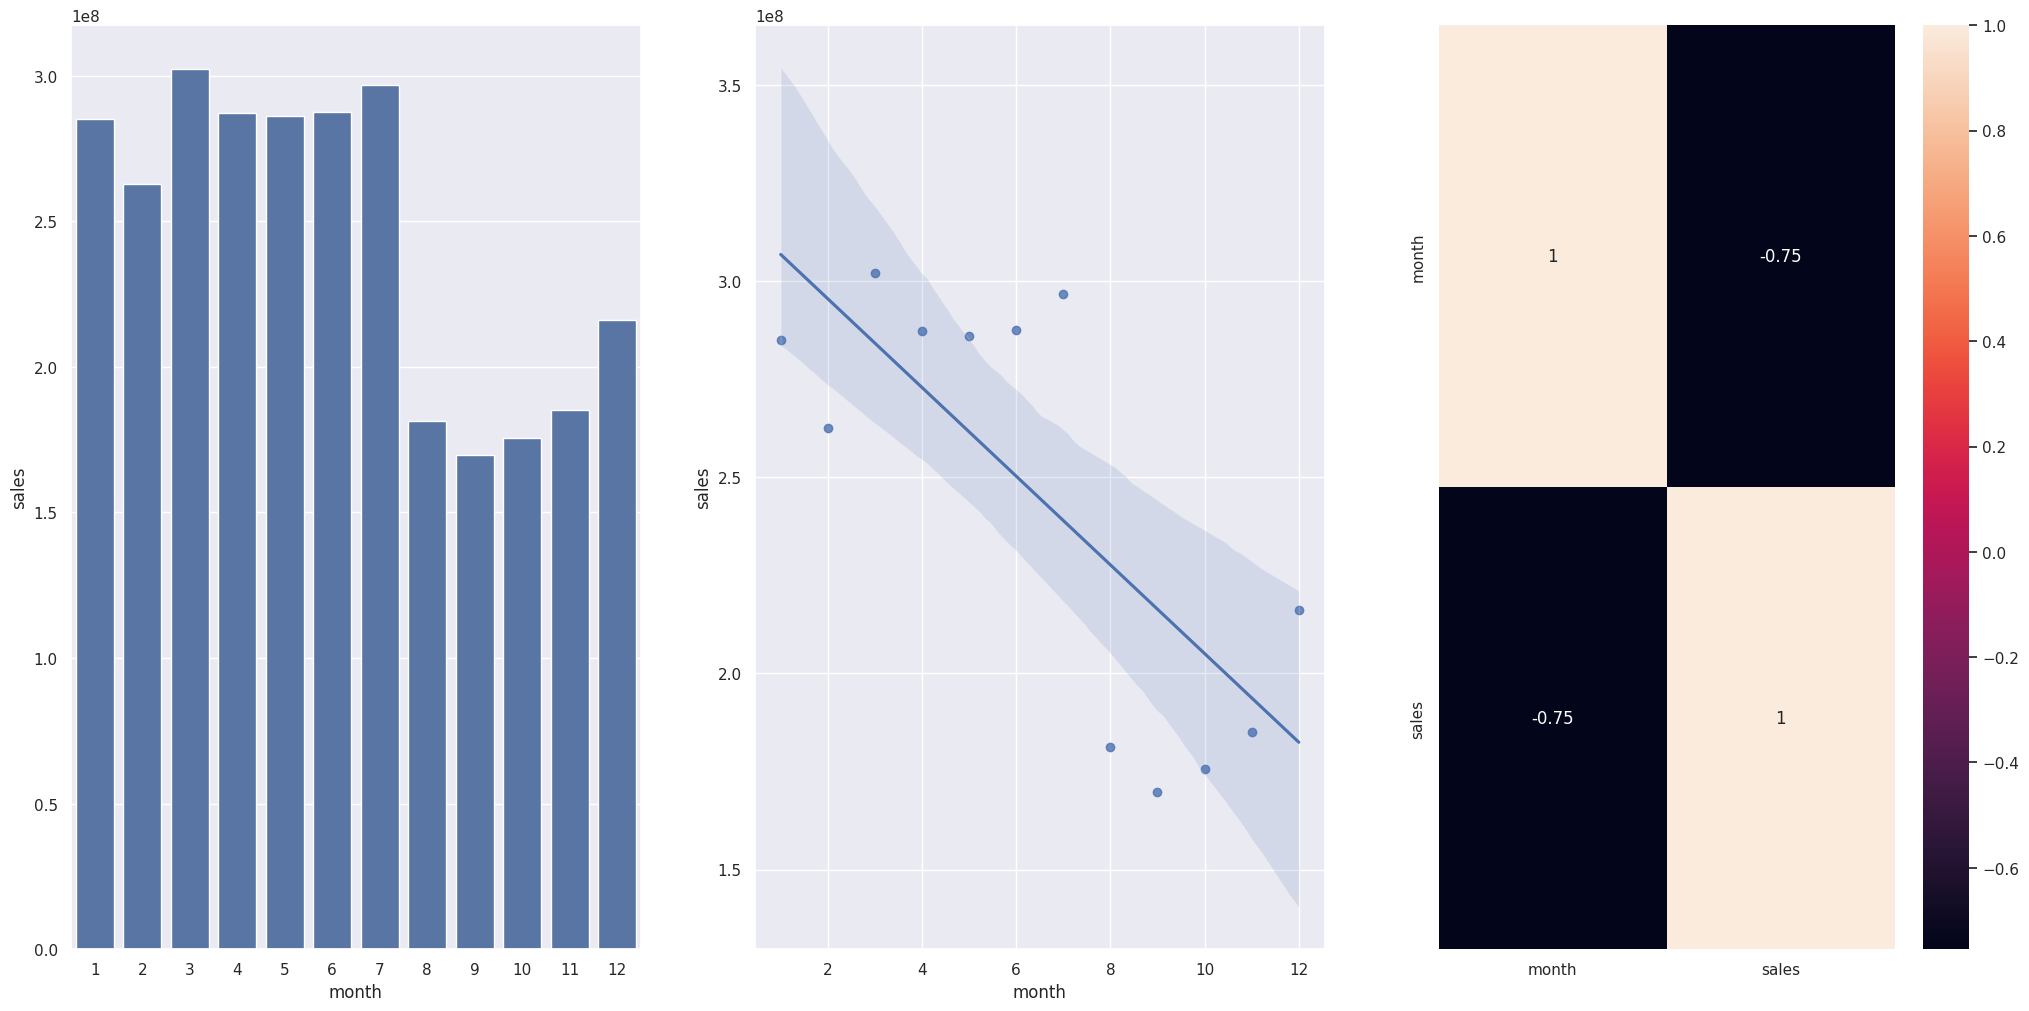

In [40]:
# Let's Group the sales in months, then we can see the behavior troughout the year.

aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


### H10. Stores should sell more after the 10th of each month
**True** Stores sell more after the 10th day of each month

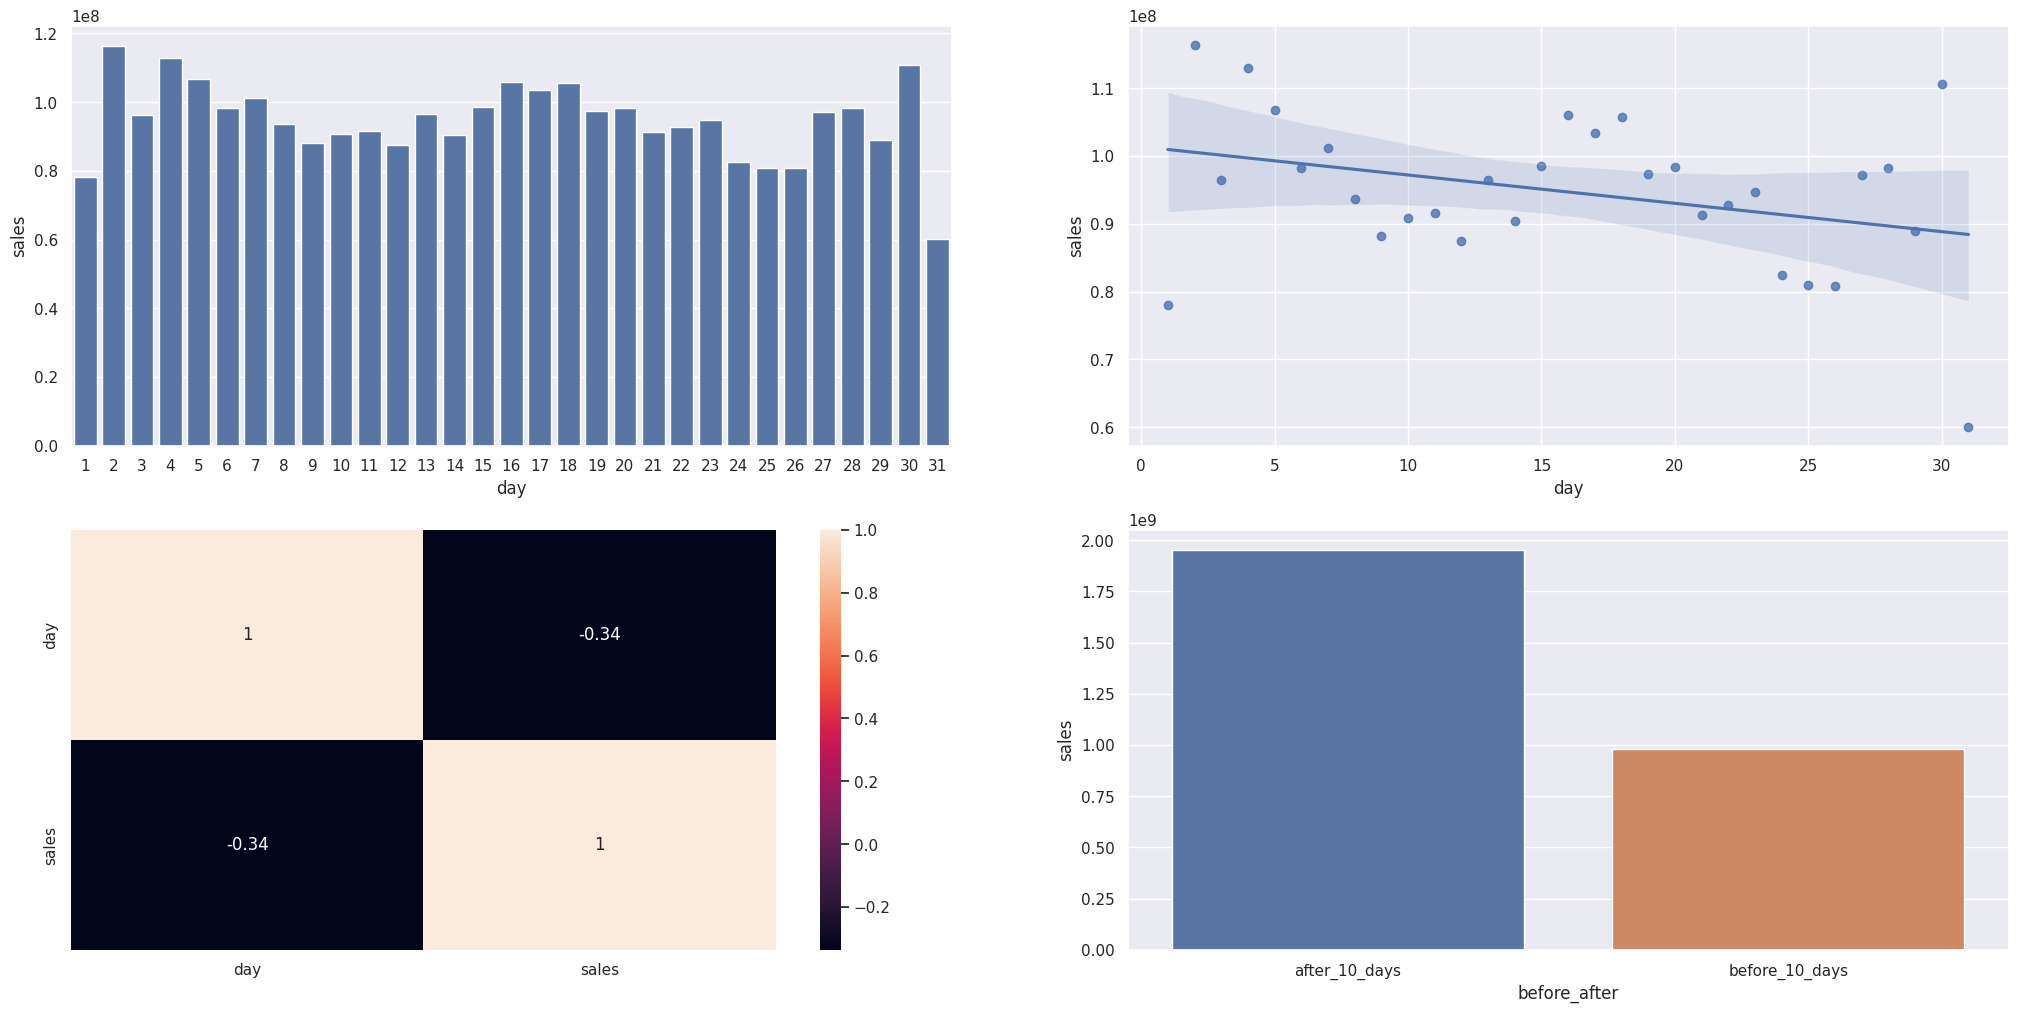

In [41]:
# Group the sales in each day of the month

aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

# Filter in two groups, before day 10 and after day 10

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2, hue='before_after' );


### H11. Stores should sell less in the weekends
**True** Stores sell less in the weekend

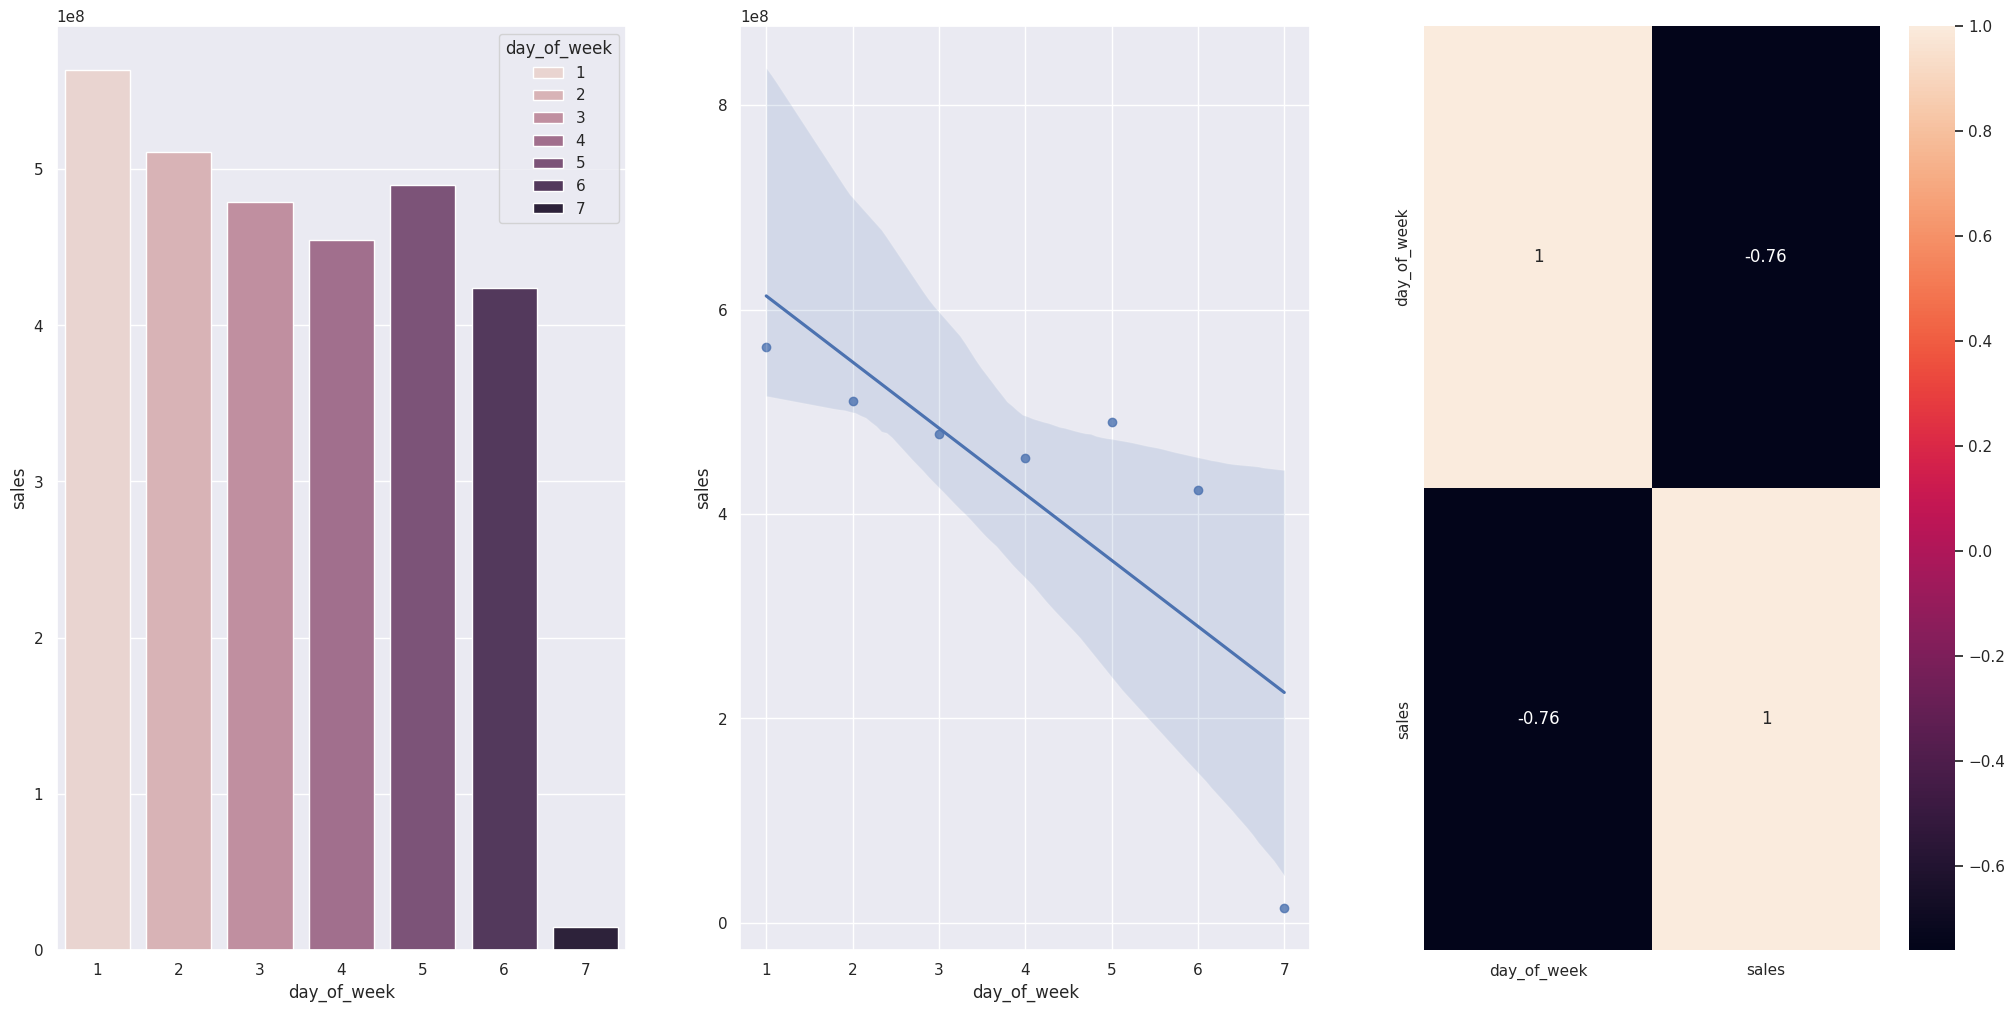

In [42]:
# Group the sales by day

aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1, hue='day_of_week' );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson'), annot=True );


### H12. Stores should sell less during scholar holidays
**True** Stores sell less during the scholar holidays but in August, and july we have almost the same number

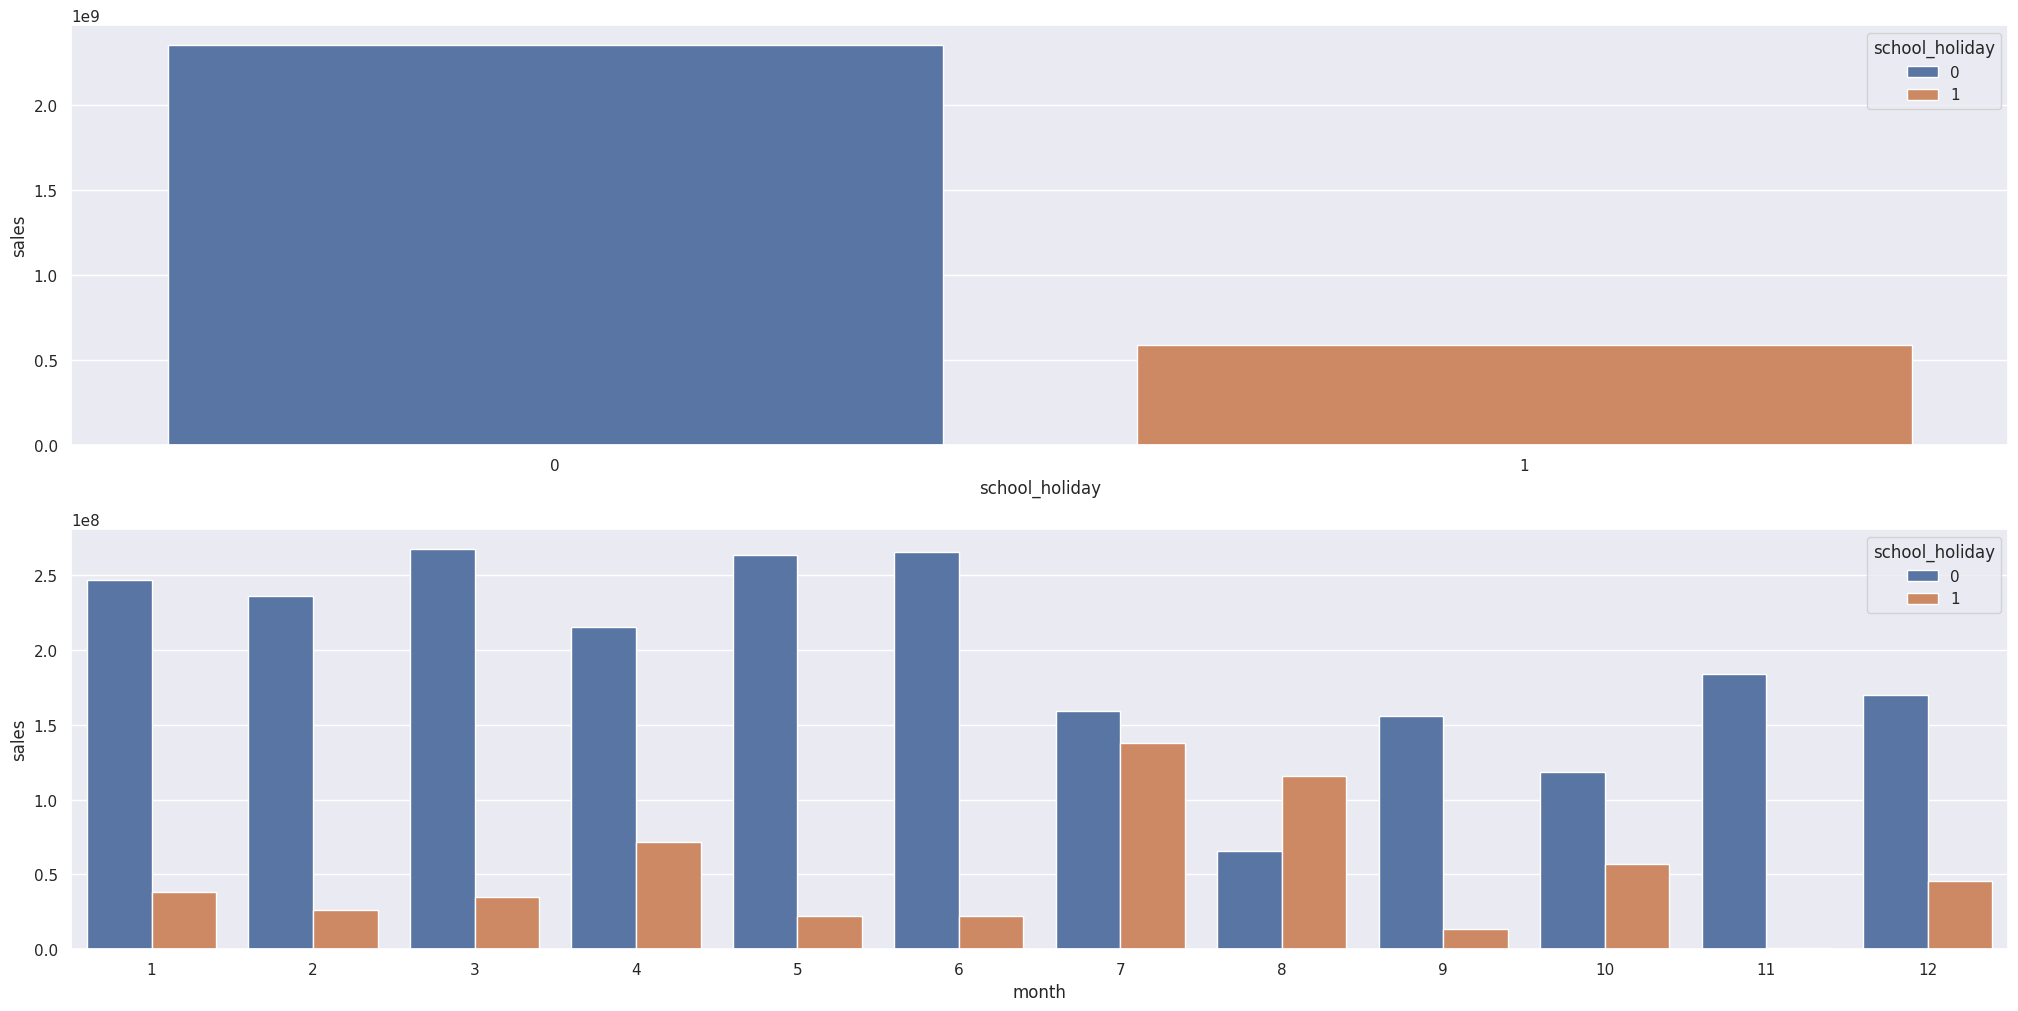

In [43]:
# Group by school holiday yes or not

aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1, hue='school_holiday' );

# filter deeper to see the diferrence throughout the months

aux2 = df4[['month', 'school_holiday', 'sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()

plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );


### Hypothesis Results

In [44]:
# Check the charts we made, and see how influent is each variable regarding the variable response (sales)

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## Save the Data ( checkpoint 5 )

In [45]:
# The dataset has suffered a lot changes and to not need to model and clean again will save the data prepared

df4.to_csv( 'checkpoint_5.csv', index=False )


In [46]:
# If nescessary to restart the kernel start running from this snippet

df5 = pd.read_csv('checkpoint_5.csv' )
df5.dtypes


store                             int64
day_of_week                       int64
date                             object
sales                             int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
is_promo                          int64
year                              int64
month                             int64
day                               int64
week_of_year                      int64
year_week                        object
competition_since                object
competition_time_month            int64
promo_since                      object
promo_time_week                   int64


In [47]:
# Change some date columns

df5 = df5.astype( {'competition_since': 'datetime64[ns]',
                   'promo_since': 'datetime64[ns]',
                   'date': 'datetime64[ns]'} )

# Create the two types of Dataframe with categorical and numeral features again,

num_attributes = df5.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df5.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )


In [48]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
2,6,5,2015-07-31,5651,1,regular_day,1,a,basic,310.0,12,2013,0,31,2015,0,2015,7,31,31,2015-30,2013-12-01,20,2015-07-27,0
3,9,5,2015-07-31,8565,1,regular_day,1,a,extended,2030.0,8,2000,0,31,2015,0,2015,7,31,31,2015-30,2000-08-01,182,2015-07-27,0
4,10,5,2015-07-31,7185,1,regular_day,1,a,basic,3160.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0


# Multiple Analyze

## Numerical Attributes

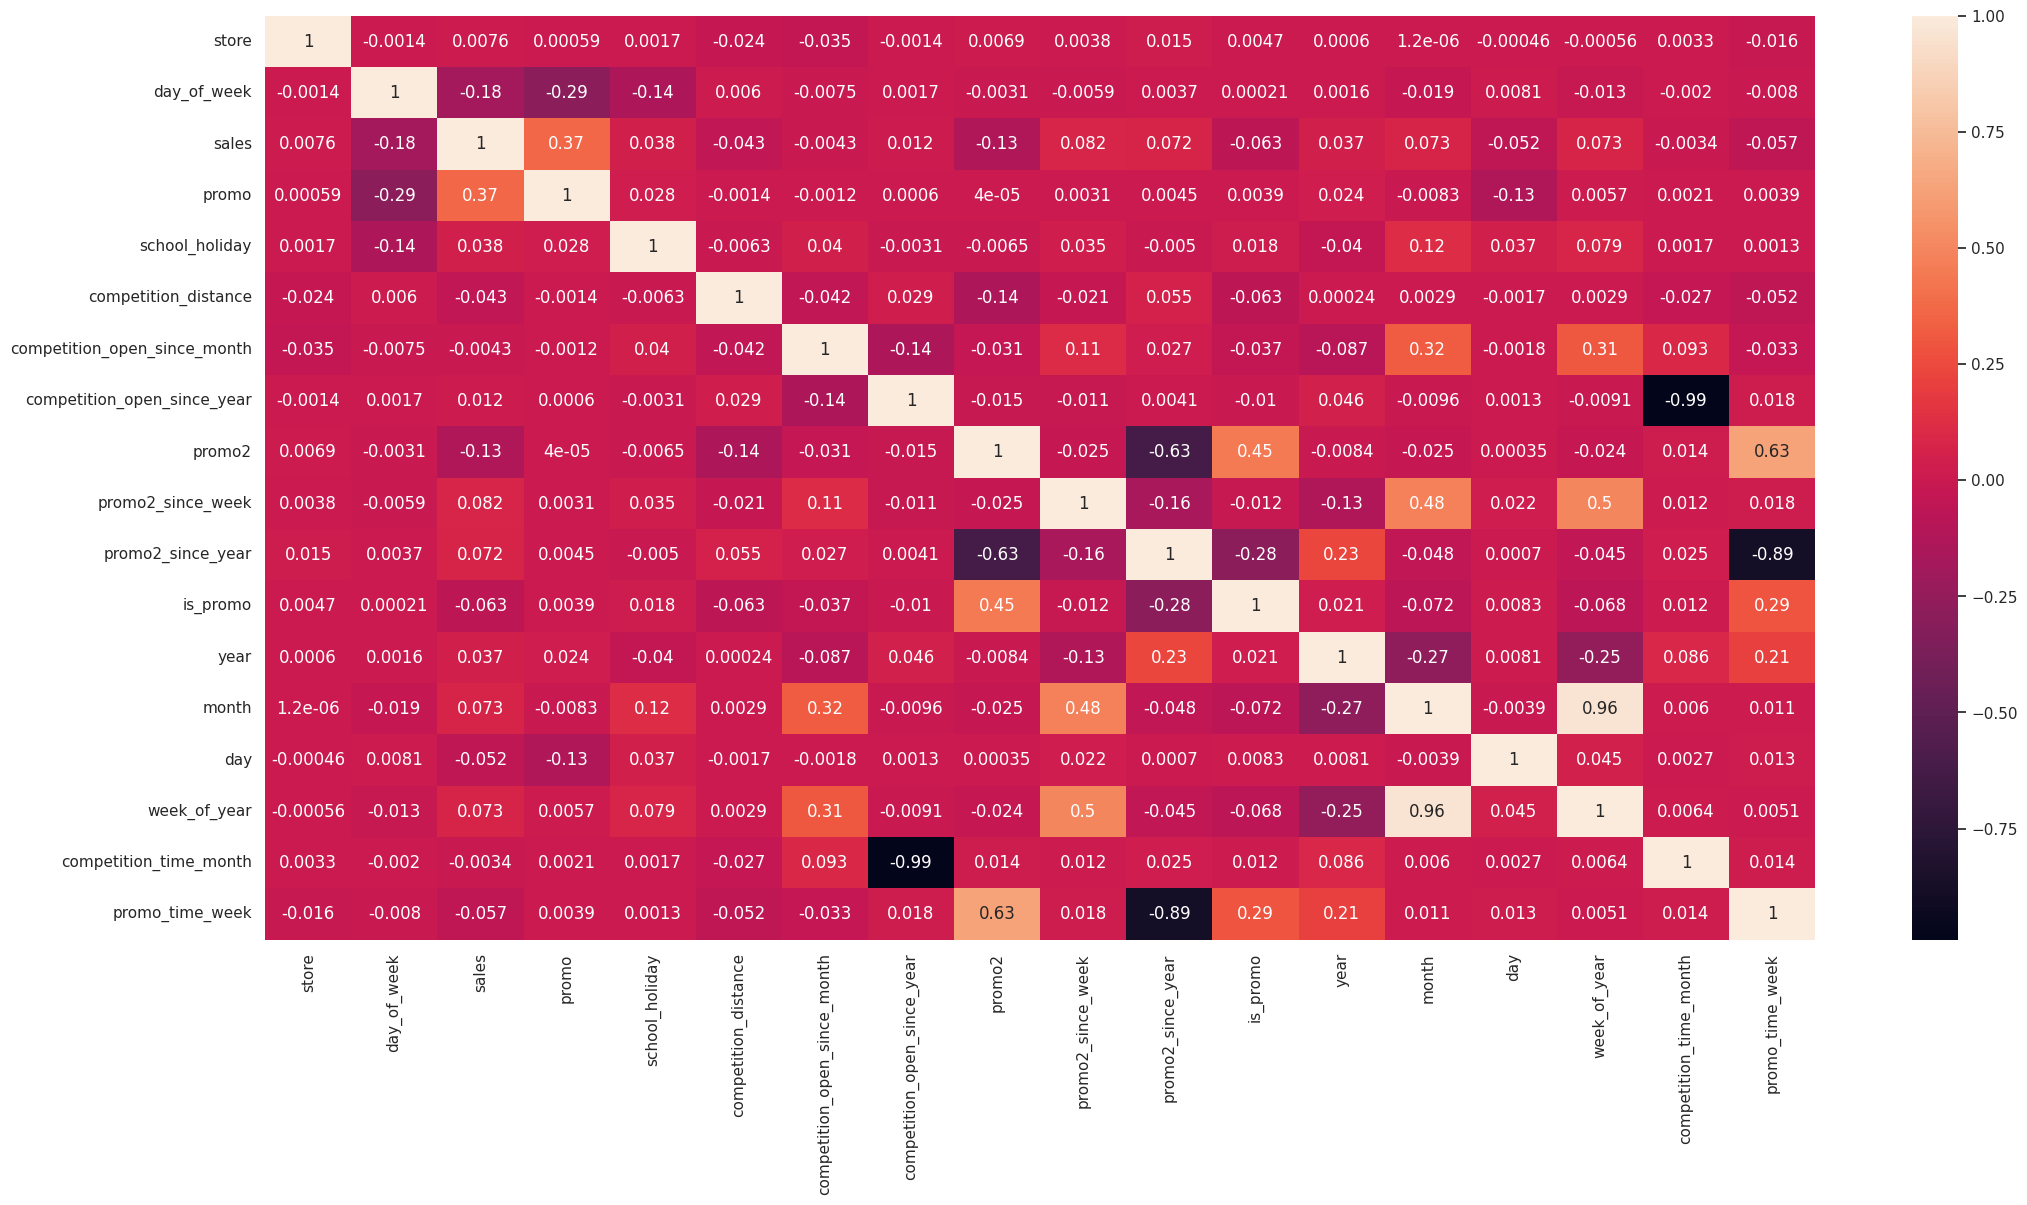

In [49]:
# Get an overview of the correlation between the numerical features

sns.heatmap( num_attributes.corr( method='pearson' ), annot=True );


## Categorical Attributes

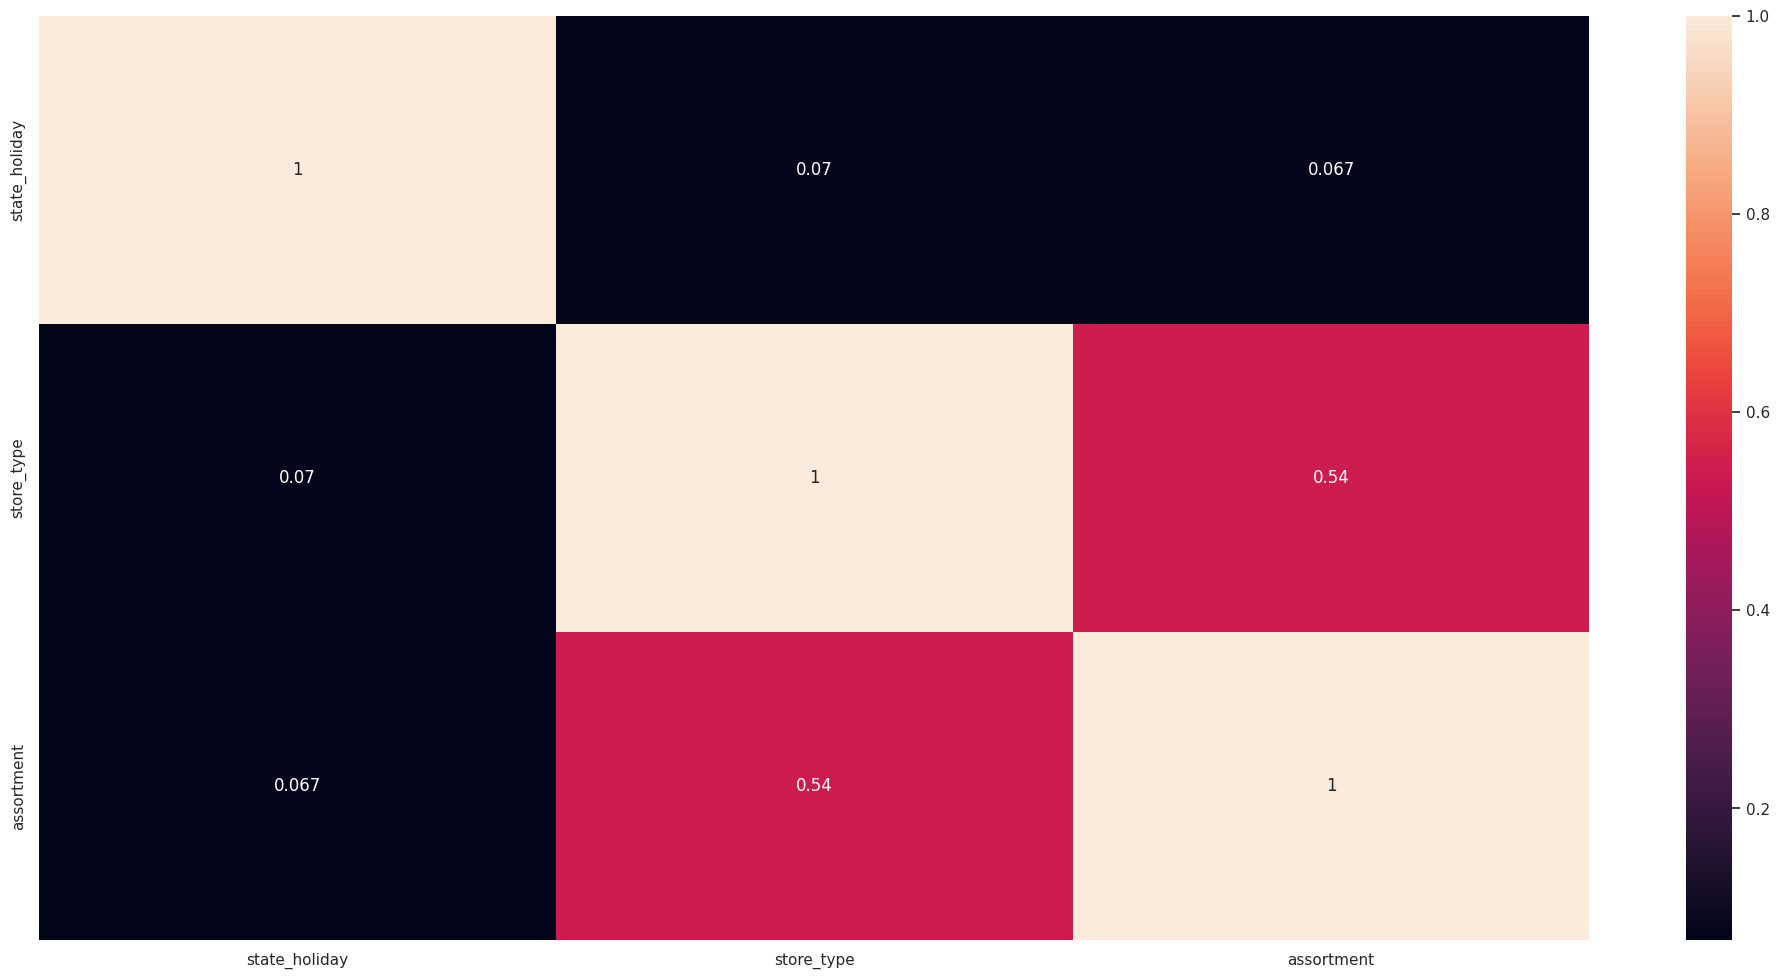

In [50]:
# Now check all the correlations among the Categorical Variables

# only categorical data

a = cat_attributes

# Calculate cramer V

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset

d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True );


# Data Preparation

## Standarlization

 We checked in (5.1.2  Numerical Variable) if we had already any normalized variable, Normal variable is when we have a variable without outliers 

## Rescaling

In [51]:
# Using methods from sklearn to rescale the variables, bringing them next to a common range

# Robustsacler is used when we have too many outliers 

rs = RobustScaler()

# MinMaxScaler is used when the variable has a pattern, with a little outliers

mms = MinMaxScaler()

# competition distance

df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month

df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week

df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year

df5['year'] = mms.fit_transform( df5[['year']].values )

pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb') )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb') )
pickle.dump( rs, open('parameter/promo_time_week_scaler.pkl', 'wb') )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb') )


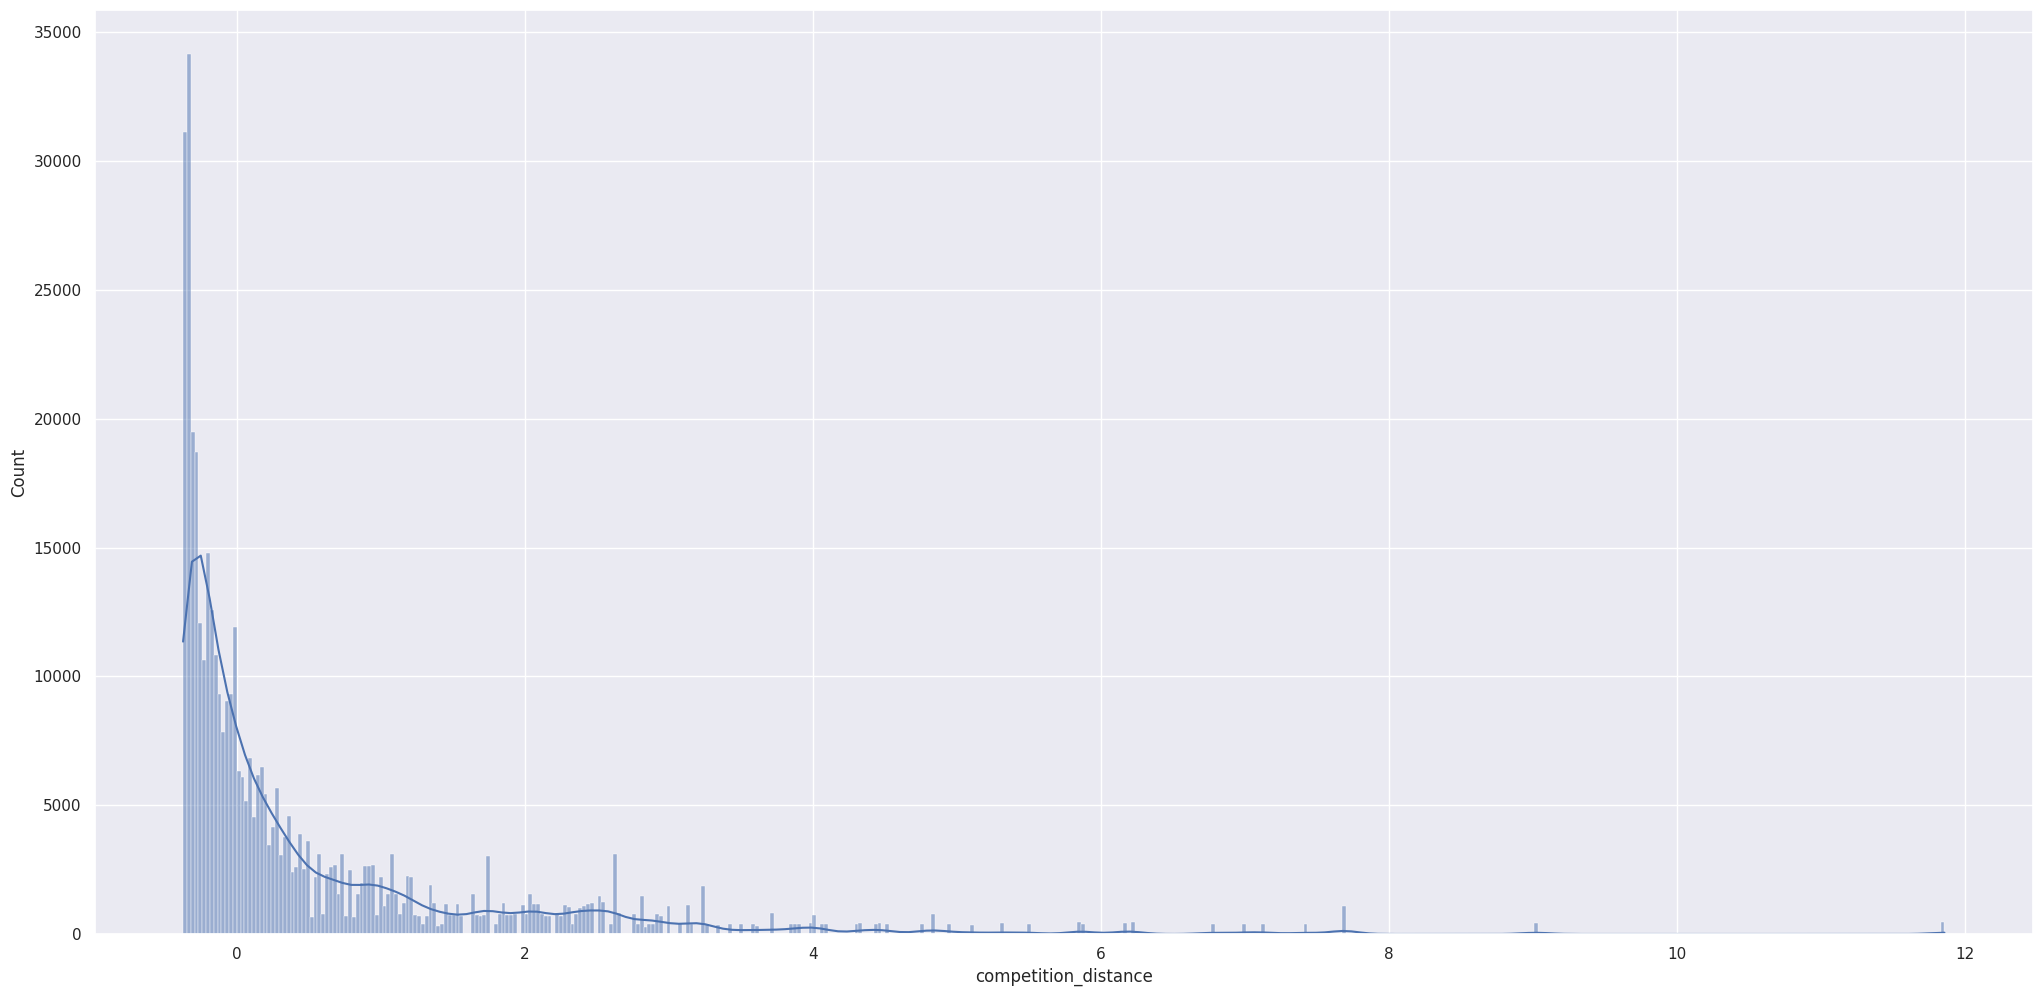

In [52]:
sns.histplot( df5['competition_distance'], kde=True);


In [53]:
df5.head()


,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
2,6,5,2015-07-31,5651,1,regular_day,1,a,basic,-0.325806,12,2013,0,31,2015,0,1.0,7,31,31,2015-30,2013-12-01,0.054054,2015-07-27,0.287016
3,9,5,2015-07-31,8565,1,regular_day,1,a,extended,-0.048387,8,2000,0,31,2015,0,1.0,7,31,31,2015-30,2000-08-01,2.243243,2015-07-27,0.287016
4,10,5,2015-07-31,7185,1,regular_day,1,a,basic,0.133871,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016


## Transformacao

### Encoding

In [54]:
# State holiday - One Hot Encoding

df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'], drop_first=True )

# Store type - Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# This code will be used in the exploitation step as API

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

pickle.dump( le, open( 'parameter/store_type_scaler.pkl', 'wb' ) )


### Response Variable Transformation

In [55]:
df5['sales'] = np.log1p( df5['sales'] )


### Nature Transformation

In [56]:
# Apply cyclical transformations for day of week

encode_cyclical_feature( df5, 'day_of_week', 7 )

# Apply cyclical transformations for month

encode_cyclical_feature( df5, 'month', 12 )

# Apply cyclical transformations for day

encode_cyclical_feature( df5, 'day', 30 )

# Apply cyclical transformations for week of year

encode_cyclical_feature( df5, 'week_of_year', 52 )


In [57]:
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,6,5,2015-07-31,8.639765,1,1,0,1,-0.325806,12,2013,0,31,2015,0,1.0,7,31,31,2015-30,2013-12-01,0.054054,2015-07-27,0.287016,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,9,5,2015-07-31,9.055556,1,1,0,3,-0.048387,8,2000,0,31,2015,0,1.0,7,31,31,2015-30,2000-08-01,2.243243,2015-07-27,0.287016,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,10,5,2015-07-31,8.879890,1,1,0,1,0.133871,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,False,False,True,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# Feature Selection

In [58]:
# Sixth Checkpoint

df6 = df5.copy()


## Split the dataset into training and test

In [59]:
# We're gonna delete the columns that were used to create the new ones

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )


In [60]:
# Training dataset

x_train = df6[df6['date'] < '2015-06-16']
y_train = x_train['sales']

# Test dataset

x_test = df6[df6['date'] >= '2015-06-16']
y_test = x_test['sales']

print( f"Training min date {x_train['date'].min()}" )
print( f"Training max date {x_train['date'].max()}" )
print( f"\nTest min date {x_test['date'].min()}" )
print( f"Test max date {x_test['date'].max()}" )
print( "\nTraining set size:", len( x_train ) )
print( "Test set size:", len( x_test ) )
print( f"\nPercentage of training { len( x_train ) / ( len( x_train ) + len( x_test ) ):.2f}" )
print( f"Percentage of test {len( x_test ) / ( len( x_train ) + len( x_test ) ):.2f}" )

# We consider the test being the last 6 weeks in the data set, since we're gonna calculate the next 6 week's sales


Training min date 2013-01-01 00:00:00
Training max date 2015-06-15 00:00:00

Test min date 2015-06-16 00:00:00
Test max date 2015-07-31 00:00:00

Training set size: 400012
Test set size: 22295

Percentage of training 0.95
Percentage of test 0.05


In [64]:
# Extract features and target variable

x_train_n = x_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

# Define the model to use for RFE

model = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 )

# Initialize RFE with the model and number of features to select

rfe = RFE( model, n_features_to_select=None, verbose=2 )

# Fit RFE to the training data

rfe.fit( x_train_n, y_train_n )


Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


RFE(estimator=RandomForestRegressor(n_jobs=-1, random_state=42), verbose=2)

In [66]:
# Get selected feature indices

cols_selected = rfe.support_.tolist()

# best features
x_train_fs = x_train.drop( ['date', 'sales'], axis=1 )
cols_selected_rfe = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_rfe = list( np.setdiff1d( x_train_fs.columns, cols_selected_rfe ) )


In [67]:
cols_selected_rfe

['store',
 'promo',
 'store_type',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2_since_week',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_cos']

## Manual Feature Selection

In [68]:
cols_selected_rfe = ['store',
 'promo',
 'store_type',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2_since_week',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_cos']

# columns to add

feat_to_add = ['date', 'sales']

cols_selected_rfe_full = cols_selected_rfe.copy()
cols_selected_rfe_full.extend( feat_to_add )


# Machine Learning Modelling (Seventh Step)

In [69]:
x_train_ML = x_train[ cols_selected_rfe ]
x_test_ML = x_test[ cols_selected_rfe ]

# Time Series Data Preparation

x_training = x_train[ cols_selected_rfe_full ]


## Average Model

In [70]:
aux1 = x_test_ML.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
round( baseline_result, 2 )


,Model Name,MAE,MAPE,RMSE
0,Average Model,1325.12,0.2,1790.4


## Linear Regression Model

In [71]:
# model

lr = LinearRegression().fit( x_train_ML, y_train )

# Prediction

yhat_lr = lr.predict( x_test_ML )

# perfomance

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
round( lr_result, 2 )


,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1921.6,0.31,2711.59


### Linear Regression Model - Cross Validation

In [72]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False )
round( lr_result_cv , 2 )


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2116.36 +/- 265.13,0.3 +/- 0.01,3016.47 +/- 426.49


## Linear Regression Regularized Model - Lasso

In [73]:
# model

lrr = Lasso( alpha=0.01 ).fit( x_train_ML, y_train )

# prediction

yhat_lrr = lrr.predict( x_test_ML )

# performance

lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
round( lrr_result, 2 )


,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1935.88,0.3,2796.23


### Lasso - Cross Validation

In [74]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2161.97 +/- 290.57,0.3 +/- 0.01,3125.39 +/- 443.75


## Random Forest Regressor

In [76]:
# model

rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_ML, y_train )

# prediction

yhat_rf = rf.predict( x_test_ML )

# performance

rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
round( rf_result, 2 )


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,716.15,0.11,1045.58


### Random Forest Regressor - Cross Validation

In [77]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,935.63 +/- 287.79,0.13 +/- 0.03,1441.81 +/- 485.97


## XGBoost Regressor

In [78]:
# model

model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=200, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train_ML, y_train )

# prediction

yhat_xgb = model_xgb.predict( x_test_ML )

# performance

xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
round( xgb_result, 2 )


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1585.04,0.23,2315.25


### XGBoost Regressor - Cross Validation

In [79]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv



KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1748.86 +/- 212.11,0.24 +/- 0.01,2549.31 +/- 322.17


## Compare Model's Performance

### Single Performance

In [80]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
round( modelling_result.sort_values( 'RMSE' ), 2 )


,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,716.15,0.11,1045.58
0,Average Model,1325.12,0.20,1790.40
0,XGBoost Regressor,1585.04,0.23,2315.25
0,Linear Regression,1921.60,0.31,2711.59
0,Linear Regression - Lasso,1935.88,0.30,2796.23


### Real Performance - Cross Validation

In [81]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2116.36 +/- 265.13,0.3 +/- 0.01,3016.47 +/- 426.49
0,Lasso,2161.97 +/- 290.57,0.3 +/- 0.01,3125.39 +/- 443.75
0,Random Forest Regressor,935.63 +/- 287.79,0.13 +/- 0.03,1441.81 +/- 485.97
0,XGBoost Regressor,1748.86 +/- 212.11,0.24 +/- 0.01,2549.31 +/- 322.17


# Hyperparameter Fine Tuning (Eitghth Step)

## Random Search

In [82]:
param = {'n_estimators': [1500, 2000, 2500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 6, 9],
    'subsample': [0.1, 0.4, 0.7],
    'colsample_bytree': [0.3, 0.6, 0.9],
    'min_child_weight': [3, 8, 12]}

MAX_EVAL = 10

In [84]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # Choose the values for parameters randomly
    hp = { k: np.random.choice( v, 1 )[0] for k, v in param.items() }
    print( hp )
    
    # model
    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  eta=hp['eta'], 
                                  max_depth=hp['max_depth'], 
                                  subsample=hp['subsample'],
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'] )

    # performance
    result = cross_validation( x_training, 10, 'XGBoost Regressor', model_xgb, verbose=True )
    final_result = pd.concat( [final_result, result] )
        
final_result

{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.4, 'colsample_bytree': 0.6, 'min_child_weight': 8}

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 12}

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 12}

KFold Number: 10

KFold Number: 9

KFold Number: 8

KFold Number: 7

KFold Number: 6

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 6, 'subsample': 0.4, 'colsample_bytree': 0.3, 'min_child_weight': 3}

KFold Number

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,956.91 +/- 127.04,0.14 +/- 0.01,1385.96 +/- 198.04
0,XGBoost Regressor,936.68 +/- 125.21,0.13 +/- 0.01,1355.23 +/- 194.67
0,XGBoost Regressor,1237.94 +/- 126.5,0.18 +/- 0.01,1797.33 +/- 199.37
0,XGBoost Regressor,1136.69 +/- 132.49,0.16 +/- 0.01,1641.13 +/- 203.16
0,XGBoost Regressor,1140.64 +/- 129.39,0.16 +/- 0.01,1652.94 +/- 201.65
0,XGBoost Regressor,1108.15 +/- 147.01,0.16 +/- 0.01,1607.06 +/- 226.76
0,XGBoost Regressor,1686.53 +/- 144.63,0.24 +/- 0.01,2440.09 +/- 217.7
0,XGBoost Regressor,963.51 +/- 127.81,0.14 +/- 0.01,1415.63 +/- 204.8
0,XGBoost Regressor,1278.09 +/- 135.59,0.18 +/- 0.01,1851.33 +/- 204.09
0,XGBoost Regressor,1795.59 +/- 153.82,0.26 +/- 0.01,2586.02 +/- 230.04


In [87]:
final_result.sort_values( 'RMSE CV', ascending=True )

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,936.68 +/- 125.21,0.13 +/- 0.01,1355.23 +/- 194.67
0,XGBoost Regressor,956.91 +/- 127.04,0.14 +/- 0.01,1385.96 +/- 198.04
0,XGBoost Regressor,963.51 +/- 127.81,0.14 +/- 0.01,1415.63 +/- 204.8
0,XGBoost Regressor,1108.15 +/- 147.01,0.16 +/- 0.01,1607.06 +/- 226.76
0,XGBoost Regressor,1136.69 +/- 132.49,0.16 +/- 0.01,1641.13 +/- 203.16
0,XGBoost Regressor,1140.64 +/- 129.39,0.16 +/- 0.01,1652.94 +/- 201.65
0,XGBoost Regressor,1237.94 +/- 126.5,0.18 +/- 0.01,1797.33 +/- 199.37
0,XGBoost Regressor,1278.09 +/- 135.59,0.18 +/- 0.01,1851.33 +/- 204.09
0,XGBoost Regressor,1686.53 +/- 144.63,0.24 +/- 0.01,2440.09 +/- 217.7
0,XGBoost Regressor,1795.59 +/- 153.82,0.26 +/- 0.01,2586.02 +/- 230.04


## Final Model

In [88]:
# Best parameters in random search

param_tuned = {
    'n_estimators': 2000, 
    'eta': 0.03, 
    'max_depth': 9, 
    'subsample': 0.1, 
    'colsample_bytree': 0.3, 
    'min_child_weight': 12
        }


In [89]:
# model

model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train_ML, y_train )

# prediction

yhat_xgb_tuned = model_xgb_tuned.predict( x_test_ML )

# performance

xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,818.097744,0.123647,1173.214349


In [90]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
round( mpe, 2 )


-0.03

# Interpreting the Errors (Nineth Step)

MAE (Mean Absolute Error) - equal weight to all errors

MAPE (Mean Absolute Percentage Error) - shows how far the prediction is from the real value in percentage

RMSE (Root mean square Error) - Shows a more precisely  result than MAE

MPE ( Mean percentage Error) - Most used to increase the precise of the model, and idicates if the model is underestimating or superestimating


In [93]:
df7 = x_test[ cols_selected_rfe_full ]

# Rescale

df7['sales'] = np.expm1( df7['sales'] )
df7['predictions'] = np.expm1( yhat_xgb_tuned )


## Business Performance

In [94]:
# Sum predictions

df71 = df7[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE

df7_aux1 = df7[['store', 'sales', 'predictions']].groupby( 'store' ).apply(
    lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df7_aux2 = df7[['store', 'sales', 'predictions']].groupby( 'store' ).apply(
    lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge

df7_aux3 = pd.merge( df7_aux1, df7_aux2, how='inner', on='store' )
df72 = pd.merge( df71, df7_aux3, how='inner', on='store' )

# Scenariosdf91

df72['worst_scenario'] = df72['predictions'] - df72['MAE']
df72['best_scenario'] = df72['predictions'] + df72['MAE']

# order columns

df72 = df72[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [95]:
df72.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
472,473,162115.156250,158819.941366,165410.371134,3295.214884,1.002543
908,909,91516.875000,81368.183594,101665.566406,10148.691406,0.802596
169,170,125828.203125,123982.145740,127674.260510,1846.057385,0.458042
469,470,121789.843750,116209.168593,127370.518907,5580.675157,0.450246
875,876,146410.750000,142644.852246,150176.647754,3765.897754,0.411136


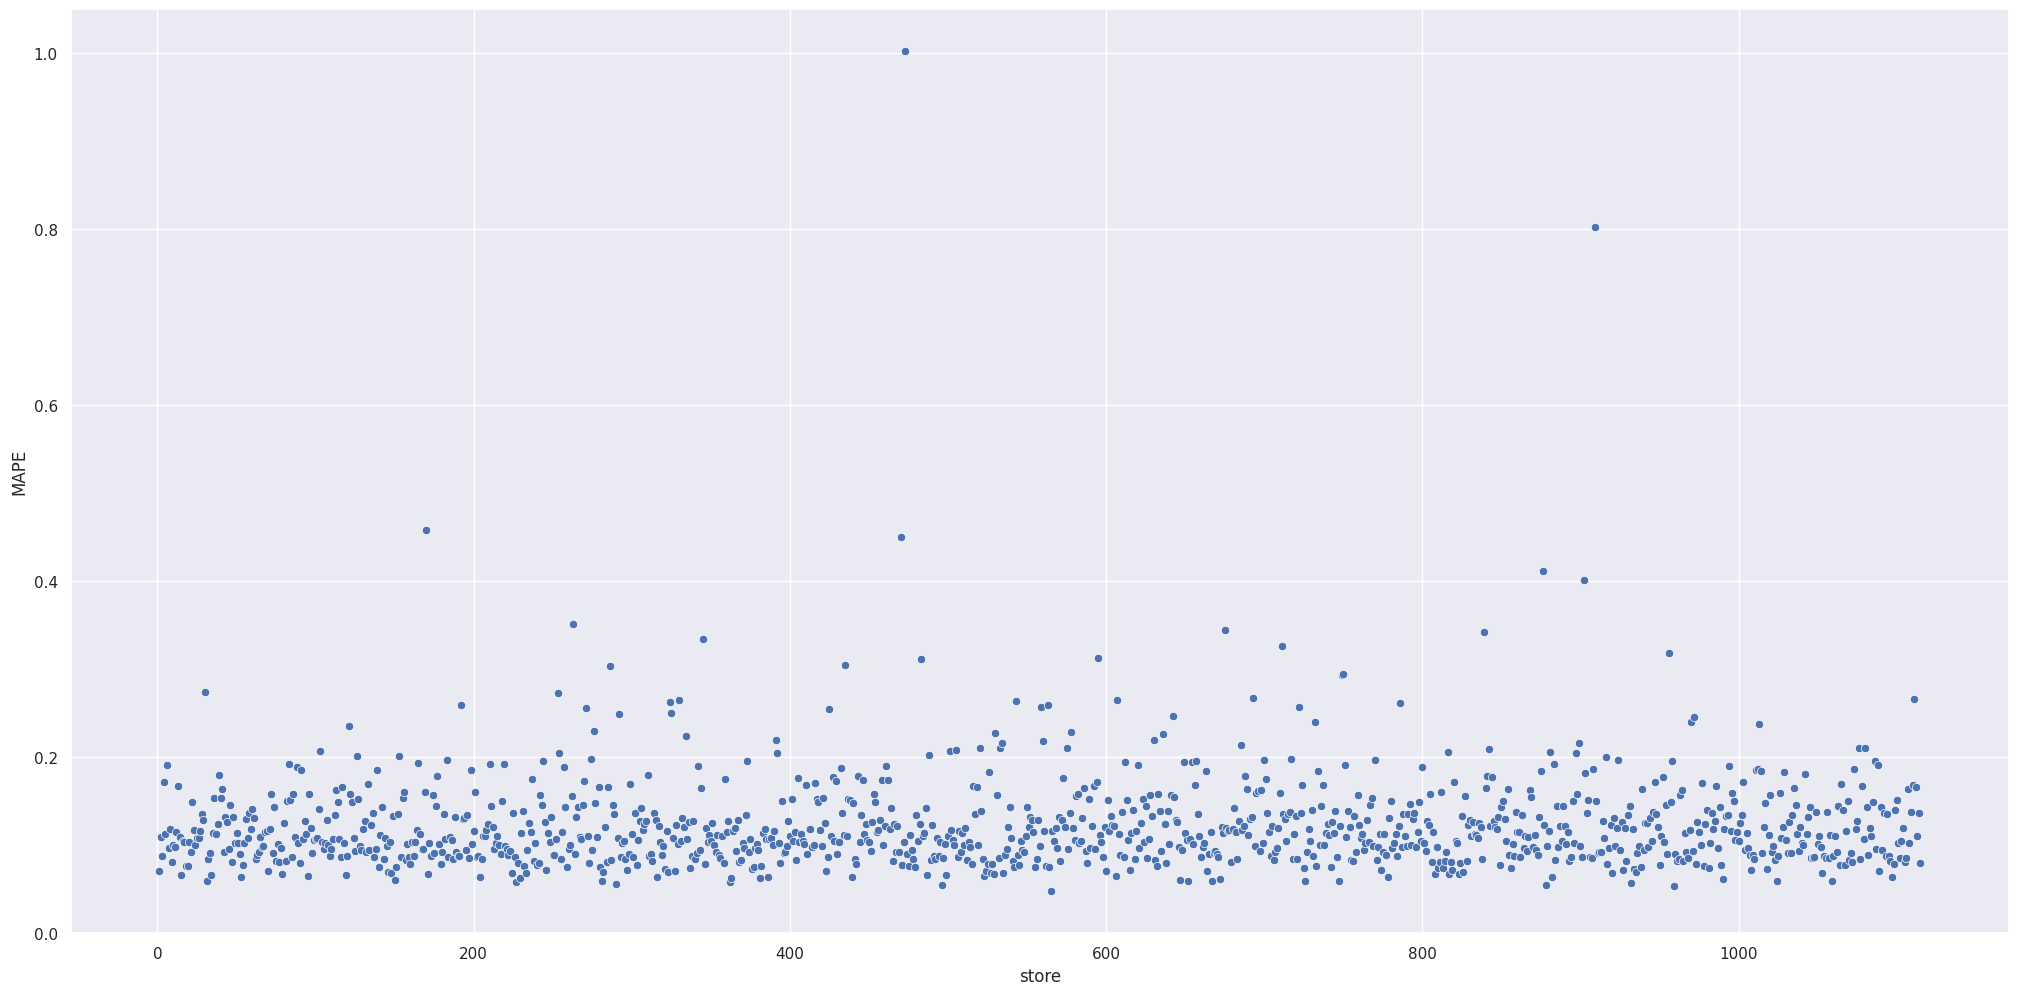

In [96]:
sns.scatterplot( x='store', y='MAPE', data=df72 );

## Total Performance

In [97]:
df73 = df72[['predictions', 'worst_scenario', 'best_scenario']].apply( 
    lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df73['Values'] = df73['Values'].map( 'EUR$ {:,.2f}'.format )
df73


,Scenario,Values
0,predictions,"EUR$ 156,365,952.00"
1,worst_scenario,"EUR$ 155,446,882.11"
2,best_scenario,"EUR$ 157,285,019.21"


## Machine Learning Performance

In [98]:
df7['error'] = df7['sales'] - df7['predictions']
df7['error_rate'] = df7['predictions'] / df7['sales']


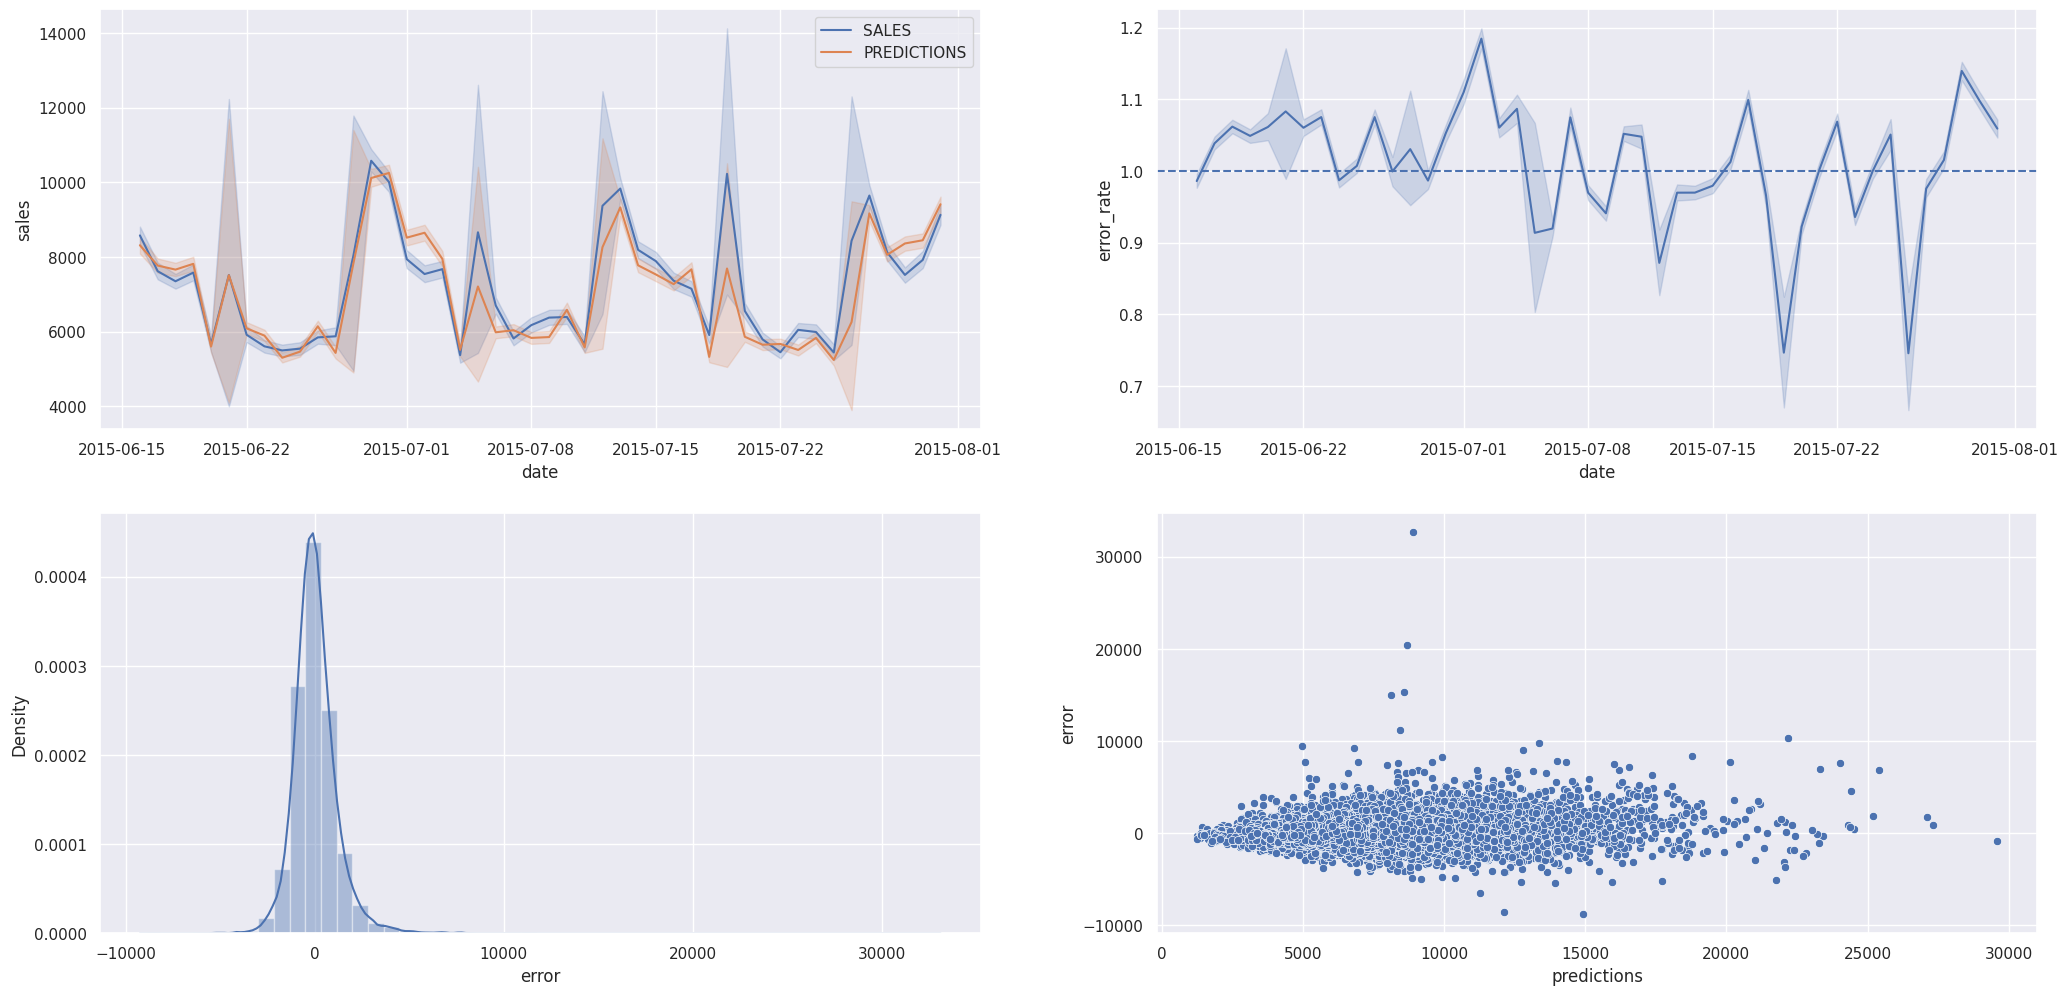

In [99]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df7, label='SALES' );
sns.lineplot( x='date', y='predictions', data=df7, label='PREDICTIONS' );

plt.subplot(2, 2, 2)
sns.lineplot( x='date', y='error_rate', data=df7 );
plt.axhline( 1, linestyle='--' )

plt.subplot(2, 2, 3)
sns.distplot( df7['error'] );

plt.subplot(2, 2, 4)
sns.scatterplot( x='predictions', y='error', data=df7 );


# Deploy Model to Production ( With Tester Local API ) (Tenth Step)

In [100]:
# Save Trained Model

pickle.dump( model_xgb_tuned, open( '/home/gabri7sc/ds_in_progress/DS_2024/Data_Science_em_Producao/rossmann_project/model/model_rossmann.pkl', 'wb' ) )


## Rossmann Class

In [115]:
import pickle
import inflection
import pandas as pd
import numpy as np
import datetime


class Rossmann( object ):
    def __init__( self ):
        self.home_path = '/home/gabri7sc/ds_in_progress/DS_2024/Data_Science_em_Producao/rossmann_project/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb' ) )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb' ) )

    def data_cleaning( self, df1 ):
        
        # Rename columns to work better further in the project
        
        cols_old = df1.columns
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        df1.columns = cols_new

        # Data Types
        
        df1['date'] = pd.to_datetime( df1['date'] )

        # Fillout NA

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 50000 if pd.isna( x ) else x )
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if pd.isna( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis=1 )
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['competition_open_since_year'] )
                                                      else x['competition_open_since_year'], axis=1 )
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if pd.isna( x['promo2_since_week'] )
                                            else x['promo2_since_week'], axis=1 )
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if pd.isna( x['promo2_since_year'] )
                                            else x['promo2_since_year'], axis=1 )
        month_map = {1: 'Jan',  2: 'Feb',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
        df1['promo_interval'] = df1['promo_interval'].fillna( 0 )
        df1['month_name'] = df1['date'].dt.strftime( '%b' )
        df1['is_promo'] = df1.apply( lambda x: 1 if x['promo_interval'] != 0 and x['month_name'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        # Change Data Types
        
        df1 = df1.astype( {'competition_open_since_month': int,
                           'competition_open_since_year': int,
                           'promo2_since_week': int,
                           'promo2_since_year': int} )
        return df1

    def feature_engineering( self, df2 ):
        
        # Adding new features

        df2['year'] = df2['date'].dt.year
        df2['month'] = df2['date'].dt.month
        df2['day'] = df2['date'].dt.day
        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        df2['competition_since'] = pd.to_datetime(df2['competition_open_since_year'].astype( str ) + '-' + df2['competition_open_since_month'].astype( str ) )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int )
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int )
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
        df2['state_holiday'] = df2['state_holiday'].map( {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0':'regular_day' } )

        # Filtering
        
        df2 = df2[df2['open'] != 0]
        drop_columns = ['open', 'month_name', 'promo_interval']
        df2 = df2.drop( drop_columns, axis=1 )

        return df2

    def data_preparation( self, df5 ):
        
        # Rescaling

        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        # Encoding

        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        # Nature Transformation ( Apply cyclical transformations )
        
        def encode_cyclical_feature( df, feature, period ):
            df[f'{feature}_sin'] = np.sin( 2 * np.pi * df[feature] / period )
            df[f'{feature}_cos'] = np.cos( 2 * np.pi * df[feature] / period )

        encode_cyclical_feature( df5, 'day_of_week', 7 )
        encode_cyclical_feature( df5, 'month', 12 )
        encode_cyclical_feature( df5, 'day', 30 )
        encode_cyclical_feature( df5, 'week_of_year', 52 )

        cols_selected = ['store', 'promo', 'store_type', 'competition_distance',
                         'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week',
                         'competition_time_month', 'promo_time_week', 'day_of_week_sin',
                         'day_of_week_cos', 'month_cos', 'day_cos']

        return df5[cols_selected]

    def get_prediction( self, model, original_data, test_data ):
        
        # prediction
        pred = model.predict( test_data )

        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )

        return original_data.to_json( orient='records', date_format='iso' )
        


## API Handler

In [ ]:
import os
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann import Rossmann

# loading model local Test
model_path = '/home/gabri7sc/ds_in_progress/DS_2024/Data_Science_em_Producao/rossmann_project/model/model_rossmann.pkl'
model = pickle.load(open(model_path, 'rb'))

app = Flask(__name__)


@app.route('/rossmann/predict', methods=['GET', 'POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json:  # there is data
        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:  # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    port = os.environ.get('PORT', 5000)
    app.run(host='0.0.0.0', port=port)


## API Tester

In [101]:
# loading test dataset

df10 = pd.read_csv( 'test.csv' )


In [102]:
# merge test dataset + store

df_test = pd.merge( df10, df_store, how='left', on='Store' )

# Choosing randoly stores just to test

random_stores_test = []

for i in range(10):
    random_stores_test.append( random.randint( 1, 500 ) )

# choose store for prediction

df_test = df_test[df_test['Store'].isin( random_stores_test )]

# remove closed days

df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )


In [103]:
# convert Dataframe to json

data = json.dumps( df_test.to_dict( orient='records' ) )


In [104]:
# API Call

url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://teste-rossmann-prediction-api.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )

print( 'Status Code {}'.format( r.status_code ) )


Status Code 200


In [105]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_name,is_promo,prediction
0,10,4,2015-09-17T00:00:00.000,1.0,1,0,0,a,a,3160.0,9.0,2009.0,0,38.0,2015.0,0,Sep,0,5696.660645
1,35,4,2015-09-17T00:00:00.000,1.0,1,0,0,d,c,7660.0,10.0,2000.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct",Sep,0,10064.522461
2,77,4,2015-09-17T00:00:00.000,1.0,1,0,0,d,c,1090.0,8.0,2009.0,1,10.0,2014.0,"Jan,Apr,Jul,Oct",Sep,0,6673.352051
3,117,4,2015-09-17T00:00:00.000,1.0,1,0,0,a,a,3450.0,9.0,2011.0,0,38.0,2015.0,0,Sep,0,4895.205566
4,181,4,2015-09-17T00:00:00.000,1.0,1,0,0,a,a,12610.0,3.0,2013.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Sep,0,6842.428711


In [106]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format( 
            d2.loc[i, 'store'], 
            d2.loc[i, 'prediction'] ) )

Store Number 10 will sell R$222,348.55 in the next 6 weeks
Store Number 35 will sell R$359,406.54 in the next 6 weeks
Store Number 77 will sell R$257,326.16 in the next 6 weeks
Store Number 117 will sell R$188,327.68 in the next 6 weeks
Store Number 181 will sell R$227,534.70 in the next 6 weeks
Store Number 184 will sell R$270,973.98 in the next 6 weeks
Store Number 295 will sell R$193,703.14 in the next 6 weeks
Store Number 301 will sell R$192,545.63 in the next 6 weeks
Store Number 449 will sell R$326,965.53 in the next 6 weeks


In [1]:
pip install pipreqs


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 5.5 MB/s eta 0:00:0000:01:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=1dc7c29660417a5a4912ea8b0b1a428883c4ce7132f5a0db10e68f920e0d9a55
  Stored in directory: /home/gabri7sc/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 8.18.1
    Uninstalling ipython-8.18.1:
      Successfully uninstalled ipython-8.18.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
pipreqs . --force


SyntaxError: invalid syntax (3484974825.py, line 1)

In [2]:
pip list


Package                           Version
--------------------------------- ---------------
anyio                             4.3.0
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
arrow                             1.3.0
asttokens                         2.4.1
attrs                             23.2.0
backcall                          0.2.0
beautifulsoup4                    4.12.3
bleach                            6.1.0
blinker                           1.7.0
Boruta                            0.3
certifi                           2024.2.2
cffi                              1.16.0
charset-normalizer                3.3.2
click                             8.1.7
comm                              0.2.1
contourpy                         1.2.0
cycler                            0.12.1
debugpy                           1.8.1
decorator                         5.1.1
defusedxml                        0.7.1
docopt                            0.6.2
et-xmlfile           

In [3]:
!pipreqs . --force

INFO: Not scanning for jupyter notebooks.
ERROR: Failed on file: ./Procfile.py
Traceback (most recent call last):
  File "/home/gabri7sc/.pyenv/versions/cds_projects/bin/pipreqs", line 8, in <module>
    sys.exit(main())
  File "/home/gabri7sc/.pyenv/versions/cds_projects/lib/python3.9/site-packages/pipreqs/pipreqs.py", line 609, in main
    init(args)
  File "/home/gabri7sc/.pyenv/versions/cds_projects/lib/python3.9/site-packages/pipreqs/pipreqs.py", line 533, in init
    candidates = get_all_imports(
  File "/home/gabri7sc/.pyenv/versions/cds_projects/lib/python3.9/site-packages/pipreqs/pipreqs.py", line 153, in get_all_imports
    raise exc
  File "/home/gabri7sc/.pyenv/versions/cds_projects/lib/python3.9/site-packages/pipreqs/pipreqs.py", line 139, in get_all_imports
    tree = ast.parse(contents)
  File "/home/gabri7sc/.pyenv/versions/3.9.18/lib/python3.9/ast.py", line 50, in parse
    return compile(source, filename, mode, flags,
  File "<unknown>", line 1
    web: python handler

In [4]:
!pip freeze


anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
attrs==23.2.0
backcall==0.2.0
beautifulsoup4==4.12.3
bleach==6.1.0
blinker==1.7.0
Boruta==0.3
certifi==2024.2.2
cffi==1.16.0
charset-normalizer==3.3.2
click==8.1.7
comm==0.2.1
contourpy==1.2.0
cycler==0.12.1
debugpy==1.8.1
decorator==5.1.1
defusedxml==0.7.1
docopt==0.6.2
et-xmlfile==1.1.0
exceptiongroup==1.2.0
executing==2.0.1
fastjsonschema==2.19.1
Flask==3.0.2
fonttools==4.49.0
fqdn==1.5.1
h11==0.14.0
idna==3.6
importlib_metadata==7.0.2
importlib_resources==6.1.3
inflection==0.5.1
ipykernel==6.29.3
ipython==8.12.3
ipython-genutils==0.2.0
isoduration==20.11.0
itsdangerous==2.1.2
jedi==0.19.1
Jinja2==3.1.3
joblib==1.3.2
jsonpointer==2.4
jsonschema==4.21.1
jsonschema-specifications==2023.12.1
jupyter-events==0.9.0
jupyter-highlight-selected-word==0.2.0
jupyter-nbextensions-configurator==0.6.3
jupyter_client==8.6.0
jupyter_contrib_core==0.4.2
jupyter_contrib_nbextensions==0.7.0
jupyter_core==5.7.1

In [5]:
# Define the list of libraries with their versions
libraries = [
    "Flask==3.0.2",
    "inflection==0.5.1",
    "numpy==1.26.4",
    "pandas==2.2.1",
    "scikit-learn==1.4.1.post1",
    "xgboost==2.0.3",
    "Werkzeug==3.0.1"
]

# Write the list of libraries to a requirements.txt file
with open("requirements.txt", "w") as file:
    for library in libraries:
        file.write(library + "\n")
